In [1]:
import numpy as np
import pandas as pd
import math
from scipy import *
import sys
import quadpy
import numba 
from numba import jit
from scipy.integrate import quad
from yahoo_fin.options import *
import yfinance as yf
from pandas import ExcelWriter
from yahoo_fin import stock_info as si
from pandas_datareader import data as wb
from datetime import timedelta, date
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from dateutil.parser import parse
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")
## set up of the parameters
spot = 100
strike = 100
expiry = 0.10
rate = 0.03/100 - 0.0145/100
sigma = 0.80
M = 10000
## The main simulation loop
spotT = np.empty((M, ))
callT = np.empty((M, ))
for i in range(M):
    z = np.random.normal(size=1)
    spotT[i] = spot * np.exp((rate - 0.5 * sigma * sigma)* expiry + sigma * np.sqrt(expiry) * z)#np.exp((rate + 0.5 * sigma * sigma * ( z * z - 2 ))* expiry + sigma * np.sqrt(expiry) * z)
    #np.exp((rate - 0.5 * sigma * sigma)* expiry + sigma * np.sqrt(expiry) * z)
    callT[i] = np.maximum(spotT[i] - strike, 0.0)
    price = np.exp(-rate * expiry) * callT.mean()
print("The Call Option Price is: {0:.3f}".format(price))

The Call Option Price is: 10.069


In [2]:
%%time
import numpy as np

def callTPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

spot = 4180.50
strike = 4180.50
expiry = 1
rate = 0.03/100
vol = round((0.20)**2,3)
div = 1.45/100
kappa = 1
theta = round((0.181)**2,3)
sigma = 0.14
rho = -0.9

M = 1000 # number of replications
N = int(round(252 * expiry,0))  # number of steps

dt = expiry / N

path = np.zeros(N)
var = np.zeros(N)
callT = np.zeros(M)
z1 = np.random.normal(size=(M,N))
z2 = rho * np.random.normal(size=(M,N)) + np.sqrt(1-rho**2) * z1

CPU times: user 17.3 ms, sys: 2.07 ms, total: 19.4 ms
Wall time: 18.4 ms


In [3]:
%%time
@jit(nopython=True, parallel=False,fastmath=True)
def Heston_computator(vol,kappa,theta,sigma,path,var,callT,z1,z2,strike,spot,rate,expiry):
    var = np.zeros((M,N))
    path = np.zeros((M,N))
    var[:,0] = vol
    path[:,0] = spot
    for i in numba.prange(0,M):
        for j in numba.prange(1,N):
            #simulate variance equation first
            var[i,j] = var[i,j-1] + kappa * (theta - var[i,j-1]) * dt + sigma * np.sqrt(var[i,j-1] * dt) * z2[i,j]
            path[i,j] = path[i,j-1] * np.exp((rate - div - 0.5 * var[i,j]) * dt + np.sqrt(var[i,j] * dt) * z1[i,j])
        callT[i] =  np.maximum(path[i,-1] - strike, 0.0)
    callT = np.mean(callT) * np.exp(-rate * expiry) 
    return callT,path,var

rm,Sp,Vr = Heston_computator(vol,kappa,theta,sigma,path,var,callT,z1,z2,strike,spot,rate,expiry)
result = rm
IT = M*N
fmt = "The value of the callT option is: {0:0.3f} with {1} iterations!!"
print(fmt.format(result,IT))

The value of the callT option is: 348.201 with 252000 iterations!!
CPU times: user 598 ms, sys: 40.7 ms, total: 638 ms
Wall time: 688 ms


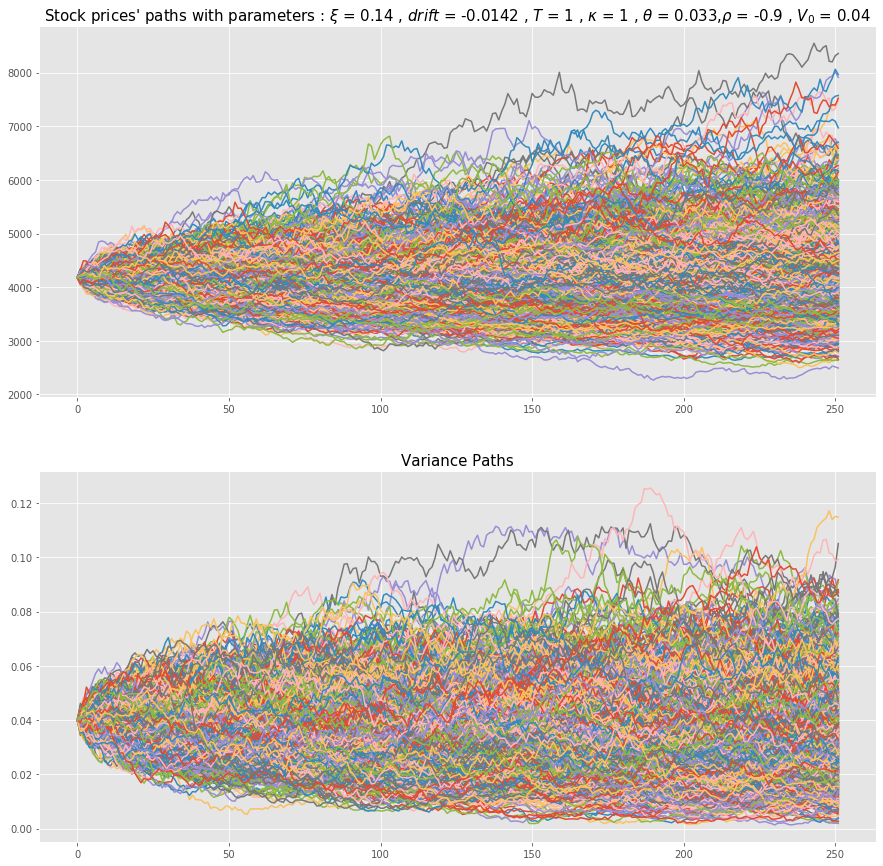

In [4]:
plt.figure(1,figsize=(15,15))
plt.subplot(211)
plt.plot(Sp.T[:,:3000])
plt.title(r"Stock prices' paths with parameters : $\xi$ = {} , $drift$ = {} , $T$ = {} , $\kappa$ = {} , $\theta$ = {},$\rho$ = {} , $V_0$ = {} ".format(sigma,np.round(rate-div,4),expiry,kappa,theta,rho,vol),fontsize=15)
plt.subplot(212)
plt.plot(Vr.T[:,:3000])
plt.title('Variance Paths',fontsize=15)
plt.show()

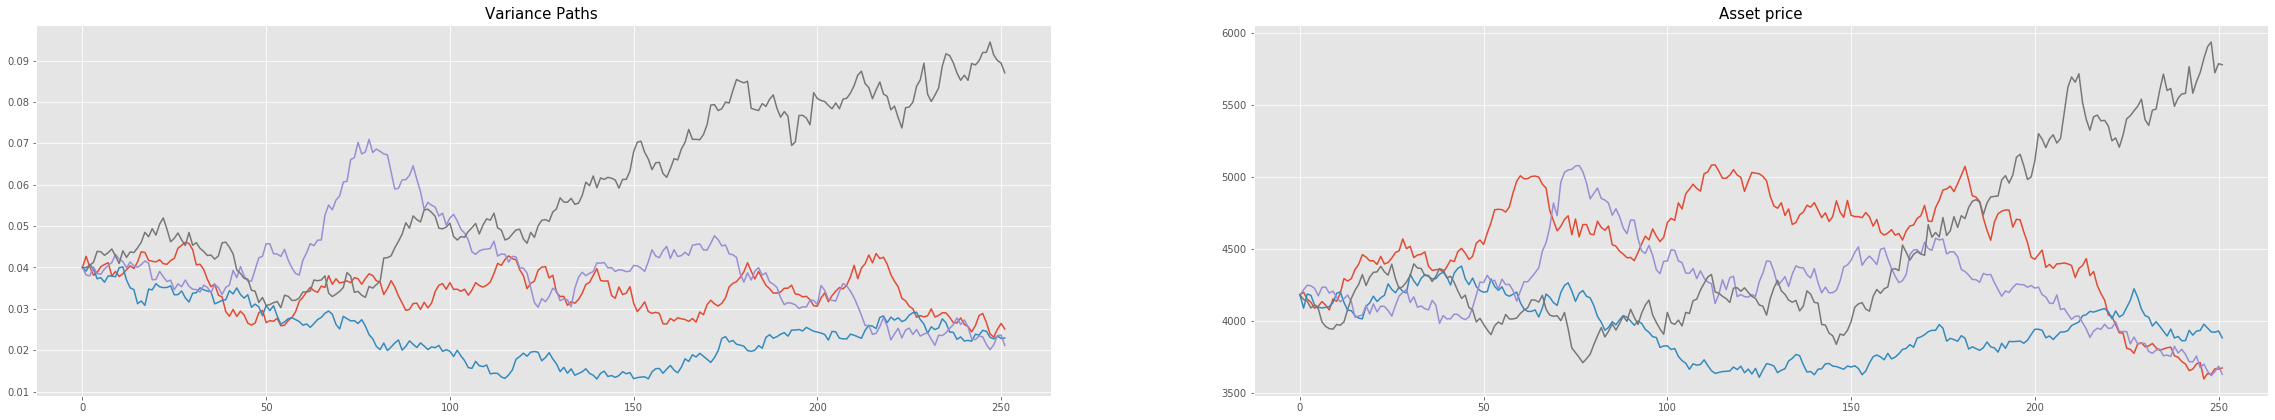

In [5]:
fig = plt.figure(figsize = (40,15))
plt.subplot(221)
plt.plot(Vr.T[:,:4])
plt.title(r'Variance Paths ',fontsize=15)
plt.subplot(222)
plt.plot(Sp.T[:,:4])
plt.title(r'Asset price',fontsize=15)
plt.show()

# Jump Merton Model 

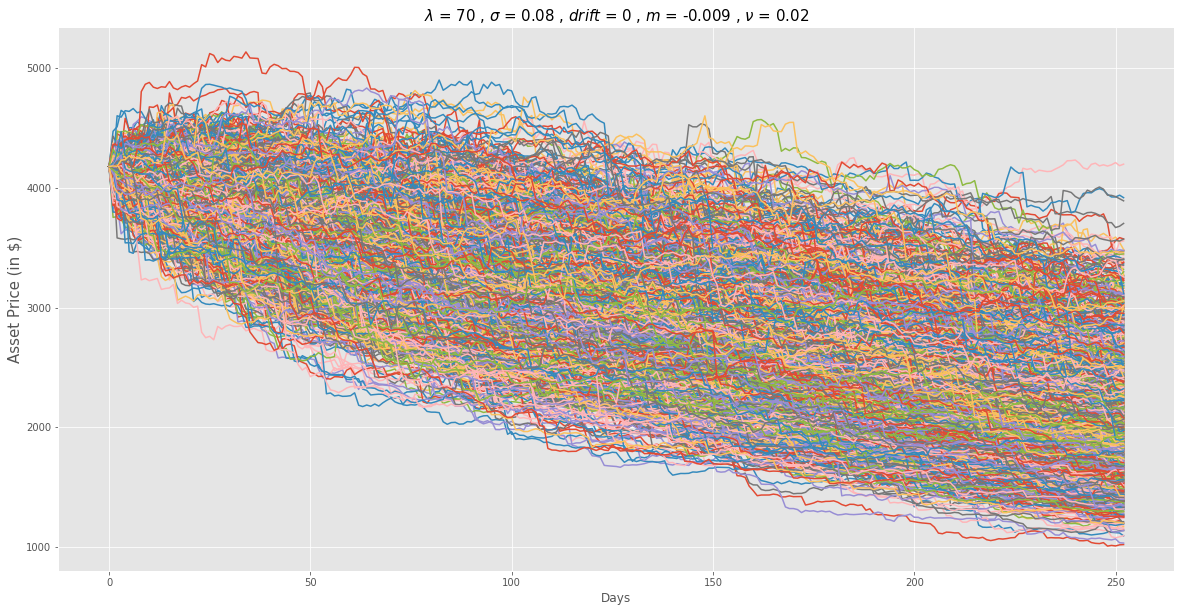

In [220]:
sigma = 0.08
lamda = 70
mu = - 0.009
v_m = 0.02
r = 0#rate - div
days = 252
N = 2000

def Jump_model(S0,sigma,lamda,mu,v_m,r,days,N):
    S_T = np.zeros((N,days + 1))
    S_T[:,0] = S0
    drift = r - lamda * (np.exp(mu + .5 * v_m ) - 1) - .5 * sigma**2
    S_T[:,1:] = S0 * np.cumprod(np.exp( drift * 1/252 + sigma * np.random.normal(0,1,size=(N,days)) * np.sqrt(1/252) 
                + (np.random.poisson(1/252 * lamda,(N,days)) * np.random.normal(mu,v_m,size=(N,days)))),axis = 1)
                                       
    return S_T

S = Jump_model(spot,sigma,lamda,mu,v_m,r,days,N)
plt.figure(figsize=(20,10))
plt.plot(S.T)
plt.title(r'$\lambda$ = {} , $\sigma$ = {} , $drift$ = {} , $m$ = {} , $\nu$ = {}'.format(lamda,sigma,np.round(r,4),mu,v_m),fontsize = 15)
plt.xlabel('Days')
plt.ylabel('Asset Price (in $)',fontsize = 15)
plt.show()

In [267]:
from pandas_datareader import data as pdr
import yfinance as yfin
from scipy.stats import norm
import seaborn as sns
yfin.pdr_override()

d = pd.DataFrame()
d['^GSPC'] = pdr.get_data_yahoo('^GSPC',start='2005-01-01')['Adj Close']
E = pd.DataFrame(S.T[:,:2000])
E = (np.log(E) - np.log(E).shift(1)).dropna().values.reshape(1,-1)[0]

[*********************100%***********************]  1 of 1 completed


In [270]:
A = np.random.normal((r - .5 * 0.15**2)*1/252,0.15 * np.sqrt(1/252),size = 900000) 

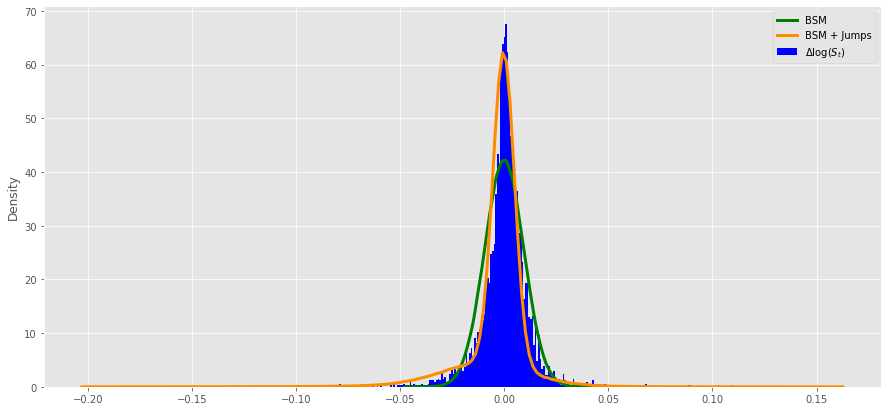

In [271]:
M = (np.log(d)-np.log(d.shift(1)))['^GSPC'].dropna()
fig = plt.figure(figsize=(15,7))
sns.distplot(A[np.abs(A)<0.2],hist = False,kde_kws={"color": "green", "lw": 3, "label": "KDE"})
sns.distplot(E[np.abs(E)<0.2],hist = False,kde_kws={"color": "darkorange", "lw": 3, "label": "KDE"})
#sns.distplot(JH,hist = False,kde_kws={"color": "green", "lw": 3, "label": "KDE"})
plt.hist(M[np.abs(M)<0.2], density=True, bins=300,color = 'blue')
plt.legend([r'BSM',r'BSM + Jumps',r'$\Delta \log(S_{t})$'])
#plt.legend([r'BSM',r'$\Delta \log(S_{t})$'])
plt.show()

# Heston ,Bates ,SVJJ models

In [272]:
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')

In [273]:
import datetime 
from datetime import date
L.iloc[:,1] = L.iloc[:,1]
L.iloc[:,2] = L.iloc[:,2]
#L = L.mask(L.Strikes>1.10 * S0).dropna()
#L = L.mask(L.Strikes<0.90 * S0).dropna()
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
#L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2  +
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360
#L = L.mask(L.TTM>400/365).dropna()

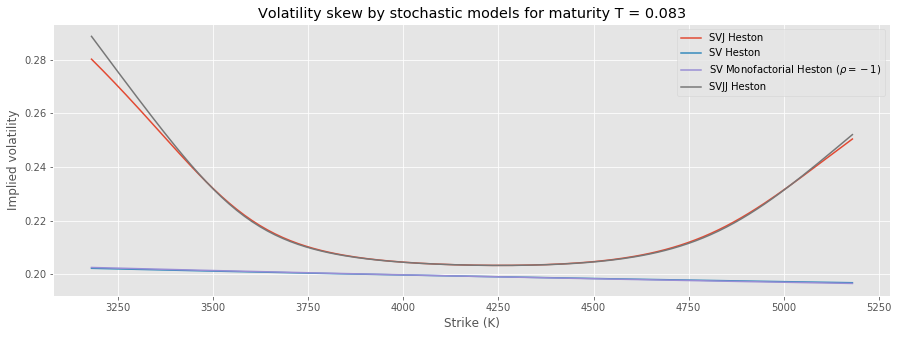

In [274]:
from scipy import *
from math import * 
from scipy.stats import norm
from scipy.optimize import fmin_bfgs
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize, rosen, rosen_der,least_squares


#public
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J,lambda_ = 0 , m = 0,sigma_v = 0,SVJJ_lambda = 0):
    p1 = __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J,lambda_, m ,sigma_v,SVJJ_lambda)
    p2 = __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J,lambda_, m ,sigma_v,SVJJ_lambda)
    C = np.maximum(s0 * p1 - K * np.exp(-r * T) * p2,0)
    #C = np.maximum(s0 * np.maximum(p1,0) - K * np.exp(-r * T) * np.maximum(p2,0),0)
    return C

def integrandd(phi):
    A = np.exp(-1j *  phi * np.log(K[:]))
    C = __fm(phi, kappa, theta, sigma, rho, v0, r, T[:], s0, status)
    B = (1j * phi)
    return (A * C / B).real

#private
def __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status,J,lambda_ , m ,sigma_v,SVJJ_lambda):
    if status == 1:
        f_inv = __f2(-1j, kappa, theta, sigma, rho, v0, r, T, s0,lambda_ , m ,sigma_v,SVJJ_lambda)
        integrand = lambda phi: (np.exp(-1j * phi * np.log(K)) * __f2(phi - 1j, kappa, theta, sigma, rho, v0, r, T, s0,lambda_ , m ,sigma_v,SVJJ_lambda) /(1j * phi * f_inv))
    else :
        integrand = lambda phi: (np.exp(-1j * phi * np.log(K)) * __f2(phi, kappa, theta, sigma, rho, v0, r, T, s0,lambda_ , m ,sigma_v,SVJJ_lambda) /(1j * phi))
    
    p = 0.50 + 1/pi * quad(integrand, 0.0, 1000)[0]#, epsabs=1e-08, epsrel=1e-08, limit=100
    return p#quadpy.quad(integrand, 0.0, 100.0)[0]


    #return (0.5 + (1 / pi) * quad(integrand, 0, 100)[0])
def __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J,lambda_ , m ,sigma_v,SVJJ_lambda):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1,J,lambda_ , m ,sigma_v,SVJJ_lambda)
def __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K,J,lambda_ , m ,sigma_v,SVJJ_lambda):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2,J,lambda_ , m ,sigma_v,SVJJ_lambda)
def density_Function(phi, kappa, theta, sigma, rho, v0, r, T, s0,K,status,lambda_ = 0 , m = 0,sigma_v = 0):
        
    b = kappa 
    x = np.log(s0)
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 + sigma**2 * (phi * 1j + phi**2))
    g = (b - rho * sigma * phi * 1j - d) / (b - rho * sigma * phi * 1j + d)
    C = (v0/sigma**2) * (b - rho * sigma * phi * 1j - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))#(r) * (phi * 1j * T) + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * np.log((1 - g * np.exp(d * T))/(1 - g))) 
    B = (theta * b / sigma**2) * (T * (b - rho * sigma * phi * 1j - d) - 2 * np.log((1 - g * np.exp(-d * T))/( 1 - g )))
    D = -lambda_  * m * phi * 1j * T  + lambda_ * T *((( 1 + m )**(1j * phi)) * np.exp(.5 * 1j * phi * sigma_v**2 * (1j * phi -1 ) ) - 1 )
    hs_init = np.exp( C + B + 1j * phi * x + D)
    res =  hs_init 
    return res

def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM

#For Matrices

def __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status, lambda_ , m ,sigma_v):
        
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa * theta
    x = np.log(s0)
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    C = (r) * (phi * 1j * T) + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * np.log((1 - g * np.exp(d * T))/(1 - g))) 
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    jump_term = np.exp(lambda_  * T * ( phi * 1j * -(np.exp( m + .5 * sigma_v**2) - 1)  +  (np.exp(phi * m * 1j - .5 * sigma_v**2 * phi ** 2) - 1 )))
    #jump_term = np.exp(-lambda_*m*1j*phi*T + lambda_*T*((1+m)**(1j*phi)*np.exp(0.5*sigma_v**2*1j*phi*(1j*phi-1))-1))
    #temp1 = lambda_*T
    #temp2 = np.power(1+m, 1j*phi)
    #temp3 = 0.5*(sigma_v**2)*1j*phi
    #temp4 = (1j*phi)-1
    #temp5 = np.exp(temp3*temp4)
    #temp6 = temp1*((temp2*temp5)-1)
    #jump_term = -lambda_ * phi * 1j * m * T  + lambda_ * T * ((1 + m)**(1j * phi) * np.exp(.5 * sigma_v**2 * 1j * phi * (1j * phi - 1)) - 1 )
    hs_init = np.exp( C + D * v0 + 1j * phi * x ) 
    res =  hs_init * jump_term
    return res

def I(t,Dp,SVJJ_lambda):
    D = t * Dp
    return np.exp(-SVJJ_lambda * D)

def __f2(phi, kappa, theta, sigma, rho, v0, r, T, s0, lambda_ , m ,sigma_v,SVJJ_lambda):
    b = kappa
    x = np.log(s0)
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 + sigma**2 * (phi * 1j + phi**2))
    g = (b - rho * sigma * phi * 1j - d) / (b - rho * sigma * phi * 1j + d)
    C = (v0/sigma**2) * (b - rho * sigma * phi * 1j - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))#(r) * (phi * 1j * T) + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * np.log((1 - g * np.exp(d * T))/(1 - g))) 
    B = (theta * b / sigma**2) * (T * (b - rho * sigma * phi * 1j - d) - 2 * np.log((1 - g * np.exp(-d * T))/( 1 - g )))
    H = lambda_ * T *((( 1 + m )**(1j * phi)) * np.exp(.5 * 1j * phi * sigma_v**2 * (1j * phi -1 ) ) - 1 )
    D = -lambda_  * m * phi * 1j * T  + H
    if SVJJ_lambda != 0:
        integrand1 = lambda t:I(t,D/T,SVJJ_lambda)
        E1 = quad(integrand1,0,T)
        E1 = E1[0] + E1[1]
        res = np.exp(C + B + 1j * phi * x + ( 1 / T ) * E1 * ( H ) + (D - H))
    else :
        res = np.exp(C + B + 1j * phi * x + D)
    return res


def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    #res = optimize.fmin(Optimisor, 0.01,(args,))
    try:
        res = brentq(Optimisor,0.0001,1000,args,maxiter=10000)
    except :
        res = np.nan
    #res = least_squares(Optimisor, 2,args = (args,))
    #res = minimize(Optimisor, 0.05,args)
    return res

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price
    
    
if __name__ == '__main__':
    #maturity
    T1 = 1/12
    T2 = 1
    r = r
    theta = (0.181)**2
    kappa = 1
    sigma = 0.01
    rho = -.90
    S0 = 4180.50
    v0 = (0.20)**2
    K = np.linspace(S0-1000,S0+1000,200)
    #simulation
    imp_vol1,imp_vol2,imp_vol3,imp_vol4 = np.array([]),np.array([]),np.array([]),np.array([])
    for k in K:
        #calc option price
        price = call_price(kappa, theta, sigma, rho, v0 ,r ,T1 ,S0 ,k,'No',0.25,0,0.1,0)
        imp_vol1 = np.append(imp_vol1,implied_volatility(price, S0, k, T1, r))
        price = call_price(kappa, theta, sigma, rho, v0 ,r ,T1 ,S0 ,k,'No',0,0,0,0)
        imp_vol2 = np.append(imp_vol2,implied_volatility(price, S0, k, T1, r))
        price = call_price(kappa, theta, sigma, -1, v0 ,r ,T1 ,S0 ,k,'No',0,0,0,0)
        imp_vol3 = np.append(imp_vol3,implied_volatility(price, S0, k, T1, r))
        price = call_price(kappa, theta, sigma, rho, v0 ,r ,T1 ,S0 ,k,'No',0.25,0,0.1,10)
        imp_vol4 = np.append(imp_vol4,implied_volatility(price, S0, k, T1, r))

    #plot result
    plt.figure(figsize=(15,5))
    plt.plot(K, imp_vol1,label = r'SVJ Heston')
    plt.plot(K, imp_vol2,label = r'SV Heston')
    plt.plot(K, imp_vol3,label = r'SV Monofactorial Heston ($\rho = -1$)')
    plt.plot(K, imp_vol4,label = r'SVJJ Heston')
    plt.xlabel('Strike (K)')
    plt.ylabel('Implied volatility')
    plt.title('Volatility skew by stochastic models for maturity T = {}'.format(round(T1,3)))
    plt.legend()
    plt.show()

In [277]:
%%time
call_price(kappa, theta, sigma, rho, v0 ,r ,1/12 ,S0 ,S0*1.20,'No',0.50,0,0.30,0)

CPU times: user 16.4 ms, sys: 919 µs, total: 17.3 ms
Wall time: 16.5 ms


9.829403139376744

In [278]:
r = 0.03/100
q = 1.45/100
T1 = 1
s0 = S0*np.exp((r-q)*T1)
K = S0
drift = r-q
#integrand = lambda phi : density_Function(phi, kappa, theta, sigma, rho, v0, r, T, s0,K,0)
#density = quad(integrand,-50,0)[0] + quad(integrand,0,50)[0]

In [279]:
import warnings
warnings.filterwarnings("ignore")
strikes = np.linspace(S0-3000,S0+4000,200)
P1 = np.ones(len(strikes))
P2 = np.ones(len(strikes))
f_inv = density_Function(-1j, kappa, theta, sigma, rho, v0, drift, T1, s0,0,0,0)
for i in range(len(strikes)):
    k = strikes[i]
    integrand0 = lambda phi:(density_Function(phi - 1j , kappa, theta, sigma, rho, v0, drift, T1, s0,k,0,0,0)/f_inv) * np.exp(-np.log(k) * phi * 1j)
    integrand1 = lambda phi:(density_Function(phi, kappa, theta, sigma, rho, v0, drift, T1, s0,k,0,0,0)) * np.exp(-np.log(k) * phi * 1j)
    density1 = (quad(integrand0,-100,0)[0] + quad(integrand0,0,100)[0])
    density2 = (quad(integrand1,-100,0)[0] + quad(integrand1,0,100)[0])
    P1[i] = density1 * 1/(2 * np.pi)
    P2[i] = density2 * 1/(2 * np.pi)

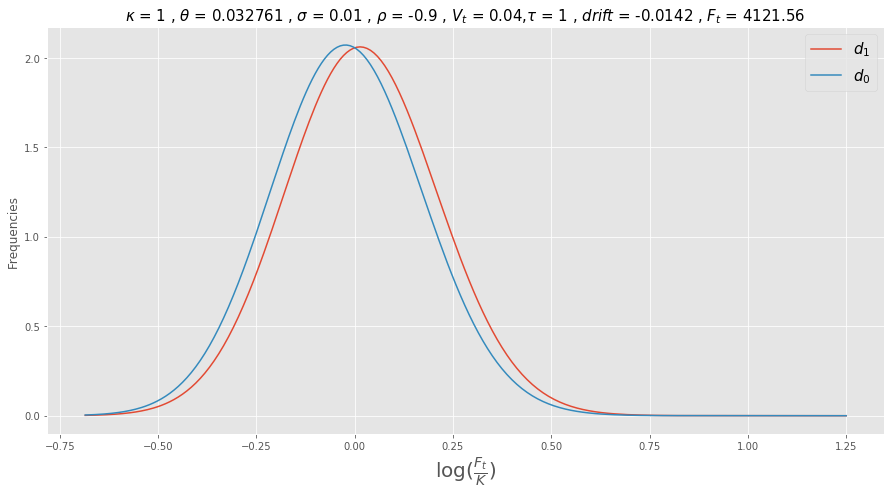

In [17]:
fig = plt.figure(figsize=(15,7.5))
plt.plot(np.log(s0/strikes),P2,label = r"$d_1$")
plt.plot(np.log(s0/strikes),P1,label = r"$d_0$")
plt.title(r"$\kappa$ = {} , $\theta$ = {} , $\sigma$ = {} , $\rho$ = {} , $V_t$ = {},$\tau$ = {} , $drift$ = {} , $F_t$ = {} ".format(kappa,theta,sigma,rho,np.round(v0,2),\
                                                      np.round(T1,2),np.round(drift,5)\
                                                      ,np.round(s0,2)),fontsize=15)
plt.xlabel(r'$\log(\frac{F_{t}}{K})$',fontsize=20)
plt.ylabel('Frequencies')
plt.legend(fontsize=15)
plt.show()

In [285]:
IV = {}
for i in range(0,len(L)):
    IVO = implied_volatility(L['Mid Price'].iloc[i],4180.50,L['Strikes'].iloc[i],L['TTM'].iloc[i],drift)
    IV[i] = IVO
IV = pd.DataFrame(IV.values(),index = IV.keys())
L['Implied Volatility'] = IV.values
Q = L.groupby(['TTM','Strikes']).mean()

In [286]:
L

IV   Bid     Ask  Strikes  Spread  Mid Price  \
OPTION EXPIRY DATE                                                     
2021-05-21          0.3571  924.3  931.1   3250.0     6.8     927.70   
2021-05-21          0.2903  628.0  633.9   3550.0     5.9     630.95   
2021-05-21          0.3329  824.9  831.7   3350.0     6.8     828.30   
2021-05-21          0.1582  158.1  161.6   4050.0     3.5     159.85   
2021-05-21          0.1873  245.1  249.5   3950.0     4.4     247.30   
...                    ...    ...    ...      ...     ...        ...   
2023-12-15          0.2369  895.0  967.0   3450.0    72.0     931.00   
2023-12-15          0.2315  825.5  897.5   3550.0    72.0     861.50   
2023-12-15          0.1902  365.3  413.3   4350.0    48.0     389.30   
2023-12-15          0.2061  525.2  573.2   4050.0    48.0     549.20   
2023-12-15          0.1854  318.7  366.7   4450.0    48.0     342.70   

                         TTM  Implied Volatility  
OPTION EXPIRY DATE                                
2021-05-21          0.097222            0.355634  
2021-05-21          0.097222            0.292970  
2021-05-21          0.097222            0.333990  
2021-05-21          0.097222            0.161763  
2021-05-21          0.097222            0.188591  
...                      ...                 ...  
2023-12-15          2.702778            0.231848  
2023-12-15          2.702778            0.227535  
2023-12-15          2.702778            0.190943  
2023-12-15          2.702778            0.205653  
2023-12-15          2.702778            0.186358  

[210 rows x 8 columns]

# Using Quantlib

In [287]:
import QuantLib as ql
from math import pow, sqrt
import numpy as np
from scipy.optimize import root

In [288]:
L = L.sort_values(by='TTM')
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
tdy = Date_16_4_21
calculation_date = ql.Date(tdy.day,tdy.month,tdy.year)

spot = S0
ql.Settings.instance().evaluationDate = calculation_date


risk_free_rate = 0.03/100
dividend_rate = 1.45/100
yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [290]:
expiration_dates = []
for s in L.index.sort_values().unique() :
    expiration_dates.append(ql.Date(s.day,s.month,s.year))
    
strikes = []
data = []
Q = L.groupby(['TTM','Strikes']).mean()
TTMs = Q.index.get_level_values('TTM').unique()
for i in TTMs:
    data.append(np.round(Q.loc[i]['Implied Volatility'].values,2).tolist())
strikes = L.Strikes.sort_values().unique().tolist()
spreads = np.abs(1/(L.groupby(['TTM','Strikes']).mean().Spread.values))
prices = (L.groupby(['TTM','Strikes']).mean())['Mid Price'].values

In [292]:
def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator1(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        if pen_c < 1e-50 :
            pen = 1e50
        #err =np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]r h in helpers]
        err =  pen * np.sum(spreads * np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)#len(helpers)
        if norm:
            return pen * err #pen * np.sum(spreads *np.abs([h.calibrationError() for h in heston_helpers4])**2/np.array(data).reshape(1,195)[0])/np.sum(spreads)
        else:
            return error
    return cost_function


def cost_function_generator2(model, helpers,norm=False,Mono = False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        err = np.sum(spreads * np.abs([h.calibrationError() for h in helpers])**2 ) * 1/np.sum(spreads)#len(helpers)
        if Mono == False :
            if pen_c < 1e-50 or params[0] < 0 or params[1]<0 or params[2]<0 or params[4]<0 or params[3] <= - 1 :
                pen = 1e50
        else :
            if pen_c < 1e-50 or params[0] < 0 or params[1]<0 or params[2]<0 or params[4]<0 or params[3] != - 1 :
                pen = 1e50
        if norm:
            return pen * err#len(heston_helpers4)
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    IVMSE = np.sum(spreads * np.array([abs(h.calibrationError())for h in helpers])**2 )/np.sum(spreads)#len(helpers)
    if detailed: print("-"*100)
    summary = "IVMSE  : %1.9f" % (IVMSE)
    print(summary)
    return IVMSE
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine
summary= []

In [293]:
from scipy.optimize import differential_evolution
model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
heston_helpers4, grid_data4 = setup_helpers(engine4, expiration_dates, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
initial_condition = (0.02, 0.2, 0.5, 0.1, 0.01)
bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10)]
bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10))
theta, kappa, sigma, rho, v0 = (0.02, 0.2, 0.5, 0.1, 0.01)

In [294]:
#Feller-Condition
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from scipy.optimize import least_squares

def Cst(x):
    theta, kappa, sigma, rho, v0 = x
    A = 2*kappa*theta - sigma**2 
    return A
const = {'type': 'ineq', 'fun': Cst}

In [295]:
%%time
cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True)
sol = differential_evolution(cost_function, bounds=bounds,tol =1e-9,maxiter = 100,popsize=100,seed = 0)
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
sol = minimize(cost_function2,sol.x, bounds=bnds,tol =1e-9,constraints = const,method = 'Nelder-Mead')
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
theta, kappa, sigma, rho, v0 = model4.params()
error = calibration_report(heston_helpers4, grid_data4)    
summary.append(["Scipy DE1", error] + list(model4.params()))  

IVMSE  : 0.000346349
CPU times: user 14min 2s, sys: 2.52 s, total: 14min 4s
Wall time: 14min 7s


# FFT Calibrations

In [296]:
# Data manipulation
import numpy as np
import pandas as pd

# For calculation and solvinge quations/optimazation
import scipy.stats as ss
import scipy.optimize as scpo
from scipy import sparse
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from functools import partial

# Result Presenting
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")

In [297]:
def fft(K, S0, r, T, cf): # interp support cubic 
    """ 
    K = vector of strike
    S0 = spot price scalar
    cf = characteristic function
    """
    N = 2**15                         # FFT more efficient for N power of 2
    B = 1e3                           # integration limit 
    
    dx = B/N
    x = np.arange(N) * dx

    weight = 3 + (-1)**(np.arange(N)+1) # Simpson weights
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    spline_cub = interp1d(ks, integral_value, kind="cubic") # cubic will fit better than linear
    prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    
    return prices

In [298]:
class Heston_process():
    def __init__(self, mu=0.1, rho=0, sigma=0.2, theta=-0.1, kappa=0.1):
        """
        r: risk free constant rate
        rho: correlation between stock noise and variance noise (|rho| must be <=1)
        theta: long term mean of the variance process(positive)
        sigma: volatility coefficient(positive)
        kappa: mean reversion coefficient for the variance process(positive)
        """
        self.mu, self.rho, self.theta, self.sigma, self.kappa = mu, rho, theta, sigma, kappa

In [299]:

# Class to price the options with the Heston model by:
class Heston_pricer():
    
    def __init__(self, Option_info, Process_info ):
        """
        Process_info: a instance of "Heston_process.", which contains (mu, rho, sigma, theta, kappa)
        Option_info: of type Option_param, which contains (S0,K,T)
        """
        self.r = Process_info.mu              # interest rate
        self.sigma = Process_info.sigma       # Heston parameters
        self.theta = Process_info.theta       
        self.kappa = Process_info.kappa       
        self.rho = Process_info.rho           
        
        self.S0 = Option_info.S0          # current price
        self.v0 = Option_info.v0          # spot variance
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity(in years)
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
    
    # payoff function
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
    
    # FFT method. It returns a vector of prices.
    def FFT(self, K,lambda_ = 0,m = 0,sigma_v = 0): # K: strikes
        K = np.array(K)
        
        # Heston characteristic function (proposed by Schoutens 2004)
        def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
            xi = kappa - sigma*rho*u*1j
            d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
            g1 = (xi+d)/(xi-d)
            g2 = 1/g1
            cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
                      + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t))) \
                      *np.exp(-lambda_  * m * u * 1j * t  + lambda_ * t *((( 1 + m )**(1j * u)) * np.exp(.5 * 1j\
                      * u * sigma_v**2 * (1j * u -1 ) ) - 1 ))
            return cf
        
        cf_H_b_good = partial(cf_Heston_good, t=self.T, v0=self.v0, mu=self.r, theta=self.theta, 
                                  sigma=self.sigma, kappa=self.kappa, rho=self.rho)
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf_H_b_good)
        elif self.payoff == "put":        # put-call parity
            return fft(K, self.S0, self.r, self.T, cf_H_b_good) - self.S0 + K*np.exp(-self.r*self.T)

In [302]:
# A class that stores option parameters (in order to write BS/Heston class neatly)
from scipy import interpolate

r = risk_free_rate - dividend_rate
class Option_param():  
    def __init__(self, S0=100, K=100, T=1, v0=0.04, payoff="call", exercise="European"):
        """
        S0: current stock price
        K: Strike price
        T: time to maturity
        v0: (optional) spot variance 
        exercise: European or American
        """
        self.S0, self.v0, self.K, self.T, self.exercise, self.payoff = S0, v0, K, T, exercise, payoff
        
def Price_calib_iv_return(x,r,Q,derivative_imp_vol = False):
    G = np.array([])
    imp_vol = np.array([])
    dstriks = 100
    imp_vol_skew = np.array([]);imp_vol_original_skew = np.array([])
    striks = np.array([])
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    for i in Q.unstack().index:
        prices, strikes, spreads = Q.loc[i].iloc[:,-2].values,Q.loc[i].index.values,1/(Q.loc[i].iloc[:,-3].values)
        opt_param = Option_param(S0=S0, K=strikes, T=i, v0=x[4], exercise="European", payoff="call" ) 
        Hest = Heston_pricer(opt_param, Heston_param)
        ATM_strike1,ATM_strike2 = strikes[9] * np.exp(r * i),strikes[9] * np.exp(-r * i)

        if len(x) == 8 :
            H  = np.maximum(Hest.FFT(strikes ,x[5], x[6], x[7]),0)
            G_1 =  np.maximum(Hest.FFT(ATM_strike1 ,x[5], x[6], x[7]),0)
            G_2 =  np.maximum(Hest.FFT(ATM_strike2 ,x[5], x[6], x[7]),0)
        else :
            H = np.maximum(Hest.FFT(strikes),0)
            G_1 =  np.maximum(Hest.FFT(ATM_strike1),0)
            G_2 =  np.maximum(Hest.FFT(ATM_strike2),0)
            
        ATM_Price = H[9]              
        G = np.append(G,H)
        striks = np.append(striks,strikes)
        AJ = np.array([implied_volatility(H[j], S0,strikes[j], i,r) for j in range(0,len(H))])
        AJ1 = np.array([implied_volatility(prices[j], S0,strikes[j], i,r) for j in range(0,len(H))])
        dstriks = 1.0001/2
        f = interpolate.interp1d(strikes, AJ1, kind='cubic')  
        imp_vol = np.append(imp_vol,AJ)
        a  = implied_volatility(G_1 , S0 , ATM_strike1, i , r) 
        b  = implied_volatility(G_2 , S0 , ATM_strike2, i , r) 
        c  = 2 * r * i
        d_ = f(ATM_strike1) #implied_volatility(prices[9] , S0 , ATM_strike1, i , r)
        m_ = f(ATM_strike2) #implied_volatility(prices[9] , S0 , ATM_strike2, i , r)
        imp_vol_skew = np.append(imp_vol_skew,( a - b ) / c )
        imp_vol_original_skew = np.append(imp_vol_original_skew,( d_ - m_ ) / c )
    if derivative_imp_vol == True :
        return imp_vol_skew,imp_vol_original_skew
    else :
        return G,striks,imp_vol

In [303]:
# The training set
from itertools import product
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

def Gaussian_Process_Interpolator(Strikes,TTM,Volatility,noise_variance):
    
    strkm = Strikes.reshape(len(Strikes),1)
    ttmm = TTM.reshape(len(TTM),1)
    X =  np.hstack((strkm,ttmm))
    Y = Volatility.reshape(len(Strikes),1)
    x,y = np.linspace(np.min(Strikes),np.max(Strikes),100),np.linspace(np.min(TTM),np.max(TTM),100)
    X,Y,Z,MSE = sk_sim(X,Y,noise_variance,x,y)
    Plotting(X,Y,Z,MSE)
    
    
def sk_sim(X,Y,noise_variance,x1,x2):
    kernel = C(0.0, (1e-3, 1e3))*RBF([1,1]) + WhiteKernel(noise_level = noise_variance)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
    gp.fit(X,Y)
    x1x2 = np.array(list(product(x1, x2)))
    y_pred = gp.predict(x1x2,return_std=False)
    y_pred2, sigma = gp.predict(X,return_std=True)
    MSE = np.mean((y_pred2 - Y)**2)
    X0p,X1p,Zp = getReshapeNZ(x1x2,y_pred)
    return X0p,X1p,Zp,MSE
    
def getReshapeNZ(S,y_pred):
    N = int(np.sqrt(len(S)))
    X0p, X1p = S[:,0].reshape(N,N), S[:,1].reshape(N,N)
    Zp = np.reshape(y_pred,(N,N))
    return X0p,X1p,Zp

def Plotting(X,Y,Z,MSE):
    fig = plt.figure(figsize=(25, 15))
    ax1 = fig.add_subplot(projection='3d')       
    surf = ax1.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap='jet', alpha=0.5)
    ax1.set_xlabel(r'$K$',fontsize = 15)
    ax1.set_ylabel(r'$TTM$',fontsize = 15)
    ax1.set_zlabel(r'$\sigma_{IV}$',fontsize = 15)
    plt.title(r'MSE = {}'.format(MSE.round(7)))
    plt.show()
    

In [304]:
def Return_df_Pricer(x,r,Q,ivmse):
    mse = 0
    rmse = 0
    aare = 0
    errors_stk_ttm = {}
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    for i in Q.unstack().index:
        prices, strikes, spreads = Q.loc[i].iloc[:,-2].values,Q.loc[i].index.values,(1/(Q.loc[i].iloc[:,-3].values))**2
        opt_param = Option_param(S0=S0, K=strikes, T=i, v0=x[4], exercise="European", payoff="call" ) 
        Hest = Heston_pricer(opt_param, Heston_param) 
        if len(x) == 8 :
            prices_calib = np.maximum(Hest.FFT(strikes ,x[5], x[6], x[7]),0)
        else :
            prices_calib = np.maximum(Hest.FFT(strikes),0)
        mse  = mse + np.sum((prices_calib - prices)**2)
        aare = aare + np.sum(np.abs(prices_calib - prices) / prices)
        errors_stk_ttm[i] = np.abs(prices_calib - prices) / prices 
    mse = mse/len(Q)
    rmse = np.sqrt(mse)
    aare = aare/len(Q) * 100
    if len(x) == 8 :
        df = pd.DataFrame([mse,aare,rmse,ivmse,int(len(Q))] + x.tolist(),index = ['MSE','AARE(in %)','RMSE','IVMSE','DATA POINTS','RHO','SIGMA','THETA','KAPPA','V0','Lambda','Mu','Sigmav'],columns = ['Summary']).T
    else :
        df = pd.DataFrame([mse,aare,rmse,ivmse,int(len(Q))] + x.tolist(),index = ['MSE','AARE(in %)','RMSE','IVMSE','DATA POINTS','RHO','SIGMA','THETA','KAPPA','V0'],columns = ['Summary']).T
    return df,errors_stk_ttm

sl = np.array([rho,sigma,theta,kappa,v0])

In [312]:
kappa_ = np.linspace(1,5,20);rho_ = np.linspace(-1,1,20)
theta_ =np.linspace(0.01,1,20)
imp_err = {}
imp_vol_ = Q.loc[L.TTM.unique()[0]]['Implied Volatility'].values 
spread_ = Q.loc[L.TTM.unique()[0]]['Spread'].values 
for i in range(0,len(kappa_)) :
    for j in range(0,len(rho_)) :
        for m in range(0,len(theta_)):
            Heston_param = Heston_process(mu=drift, rho=rho_[j], sigma=0.10, theta=theta_[m], kappa=kappa_[i])
            opt_param = Option_param(S0=S0, K=strikes, T=L.TTM.unique()[0],\
                             v0=0.01, exercise="European", payoff="call" ) 
            Hest = Heston_pricer(opt_param, Heston_param) 
            C_P = Hest.FFT(strikes)
            IV1 = np.array([implied_volatility(C_P[l], S0,k, L.TTM.unique()[0],drift) for l,k in enumerate(strikes)])
            imp_err[kappa_[i],rho_[j],theta_[m]] = np.sum(spread_*(IV1 - imp_vol_)**2/np.sum(spread_)) 

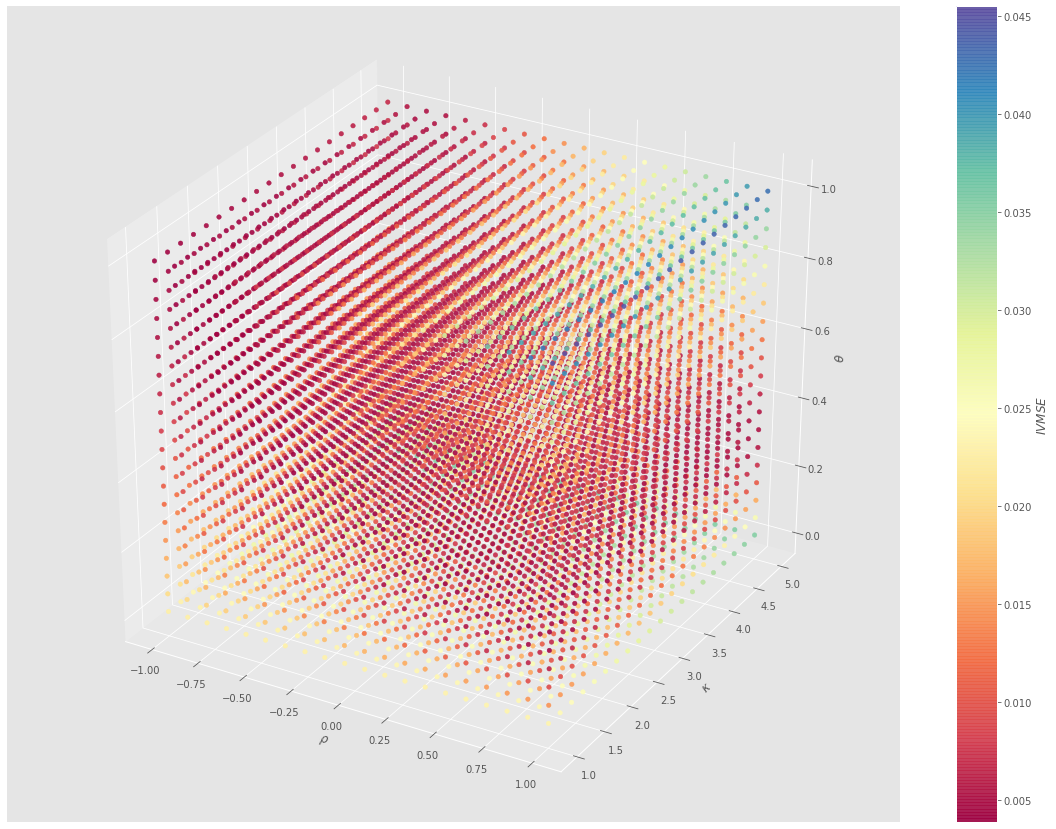

In [313]:
imp_err_ = pd.DataFrame(imp_err.values()).values.reshape(20,20,20)
xxx_, yyy_,zzz_ = np.meshgrid(kappa_,rho_,theta_)
fig = plt.figure(figsize=(20,15))
ax = fig.gca(projection='3d')
img = ax.scatter(yyy_.ravel(),xxx_.ravel(),zzz_.ravel(),c = imp_err_.ravel(), alpha=0.9,cmap = plt.cm.Spectral)
fig.colorbar(img,label=r'$IVMSE$')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\kappa$')
ax.set_zlabel(r'$\theta$')
plt.show()

In [314]:
%%time
Heston_param = Heston_process(mu=0, rho=-1, sigma=0.01, theta=0.181**2, kappa=1)
opt_param = Option_param(S0=S0, K=strikes, T=1/12, v0=0.20**2, exercise="European", payoff="call" ) 
Hest = Heston_pricer(opt_param, Heston_param) 
Hest.FFT(strikes,0.1,0.1,0.1)

CPU times: user 22.9 ms, sys: 4.18 ms, total: 27.1 ms
Wall time: 25.9 ms


array([930.50182308, 830.50746571, 730.53743577, 630.68581085,
       531.29575329, 433.32764362, 338.84543697, 251.24453448,
       174.71928206, 112.90498379,  67.39928572,  37.14549954,
        19.04626398,   9.28130949])

In [315]:
%%time
for k in strikes :
    call_price(1, 0.181**2, 0.01, -1, 0.20**2 ,0 ,1/12 ,S0 ,k,'No',0.1,0.1,0.1)

CPU times: user 168 ms, sys: 2.41 ms, total: 171 ms
Wall time: 169 ms


In [316]:
%%time
call_price(1, 0.181**2, 0.01, -1, 0.20**2 ,0 ,1/12 ,S0 ,S0,'No',0.1,0.1,0.1)

CPU times: user 12.7 ms, sys: 429 µs, total: 13.1 ms
Wall time: 12.8 ms


97.29496456429501

In [317]:
%%time
df,aare_stk_ttm = Return_df_Pricer(sl,drift,Q,error)
df

CPU times: user 285 ms, sys: 25.1 ms, total: 310 ms
Wall time: 311 ms


MSE  AARE(in %)       RMSE     IVMSE  DATA POINTS       RHO  \
Summary  153.991572    4.648267  12.409334  0.000346        210.0 -0.913736   

            SIGMA     THETA     KAPPA        V0  
Summary  0.478767  0.060704  1.887995  0.022563

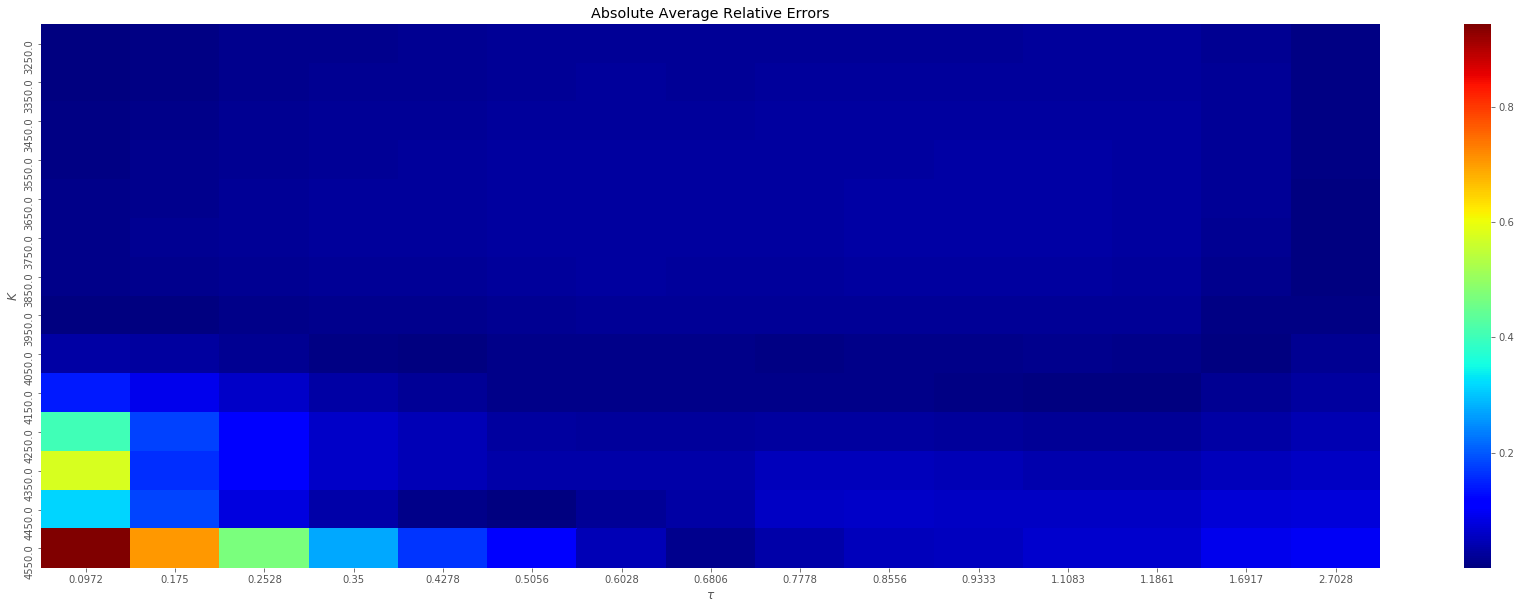

In [318]:
import seaborn as sns
Errors = pd.DataFrame(aare_stk_ttm.values(),index = aare_stk_ttm.keys())
Errors.columns = L.Strikes.sort_values().unique()
Errors.index = np.round(Errors.index.values,4)
fig = plt.figure(figsize=(30,10))
sns.heatmap(Errors.T, cmap="jet")
plt.title('Absolute Average Relative Errors')
plt.ylabel(r'$K$')
plt.xlabel(r'$\tau$')
plt.show()

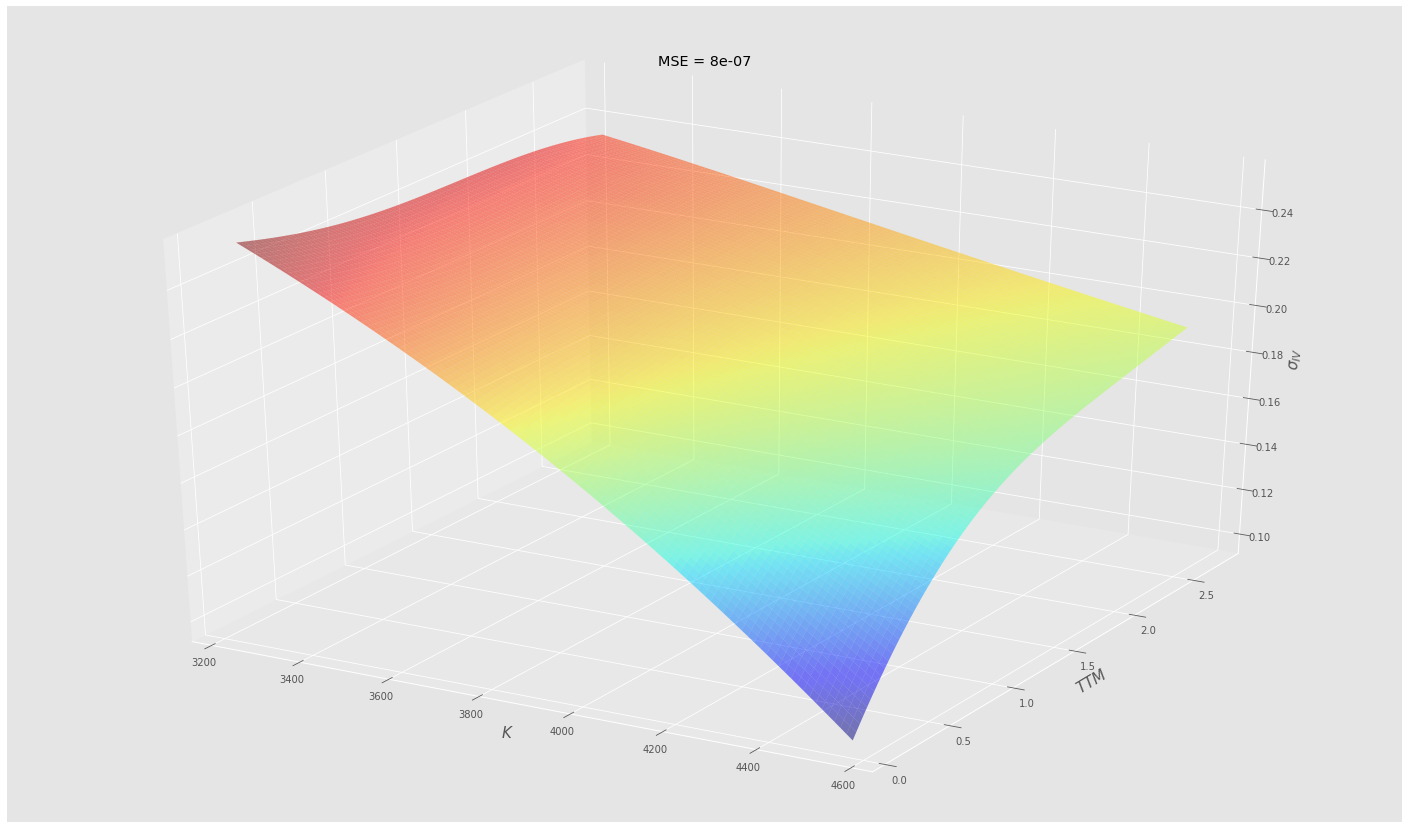

In [319]:
Prices,striks,imp_vol = Price_calib_iv_return(sl,r,Q)
TTMs = L['TTM'].values
Gaussian_Process_Interpolator(striks,TTMs,imp_vol,1)

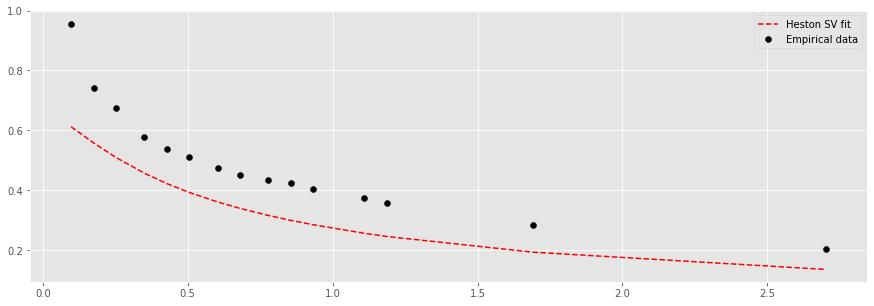

In [320]:
model1,obs = Price_calib_iv_return(sl,r,Q,True)
fig = plt.figure(figsize=(15,5))
plt.plot(L.TTM.unique(),-model1,color = 'red',ls = '--',label='Heston SV fit')
plt.scatter(L.TTM.unique(),-obs,color = 'black',label='Empirical data')
plt.legend()
plt.show()

# One factor Heston Model

# The one factor Heston Model is a one factor model.We set p = -1 using the bounds

In [321]:
%%time
bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-1,-1), (1e-5,10)]
bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-1,-1), (1e-5,10))
initial_condition = (0.02, 0.2, 0.5, 0.1, 0.01)
cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True,Mono = True)
sol = differential_evolution(cost_function, bounds=bounds,tol = 1e-9,maxiter = 100,seed = 0,popsize=100)
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
sol = minimize(cost_function2,sol.x, bounds=bnds,tol =1e-9,constraints = const,method = 'Nelder-Mead')
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
theta_nandi, kappa_nandi, sigma_nandi, rho_nandi, v0_nandi = model4.params()
error = calibration_report(heston_helpers4, grid_data4)
summary.append(["Scipy DE1", error] + list(model4.params()))

IVMSE  : 0.000394387
CPU times: user 14min 9s, sys: 1.9 s, total: 14min 11s
Wall time: 14min 34s


In [322]:
sl = np.array([rho_nandi,sigma_nandi,theta_nandi,kappa_nandi,v0_nandi])
df2,aare_stk_ttm1 = Return_df_Pricer(sl,risk_free_rate-dividend_rate,Q,error) #We evaluate the quality of the fit 
df2

MSE  AARE(in %)       RMSE     IVMSE  DATA POINTS  RHO  \
Summary  138.120638    5.210216  11.752474  0.000394        210.0 -1.0   

            SIGMA     THETA     KAPPA        V0  
Summary  0.356933  0.082582  0.772481  0.025962

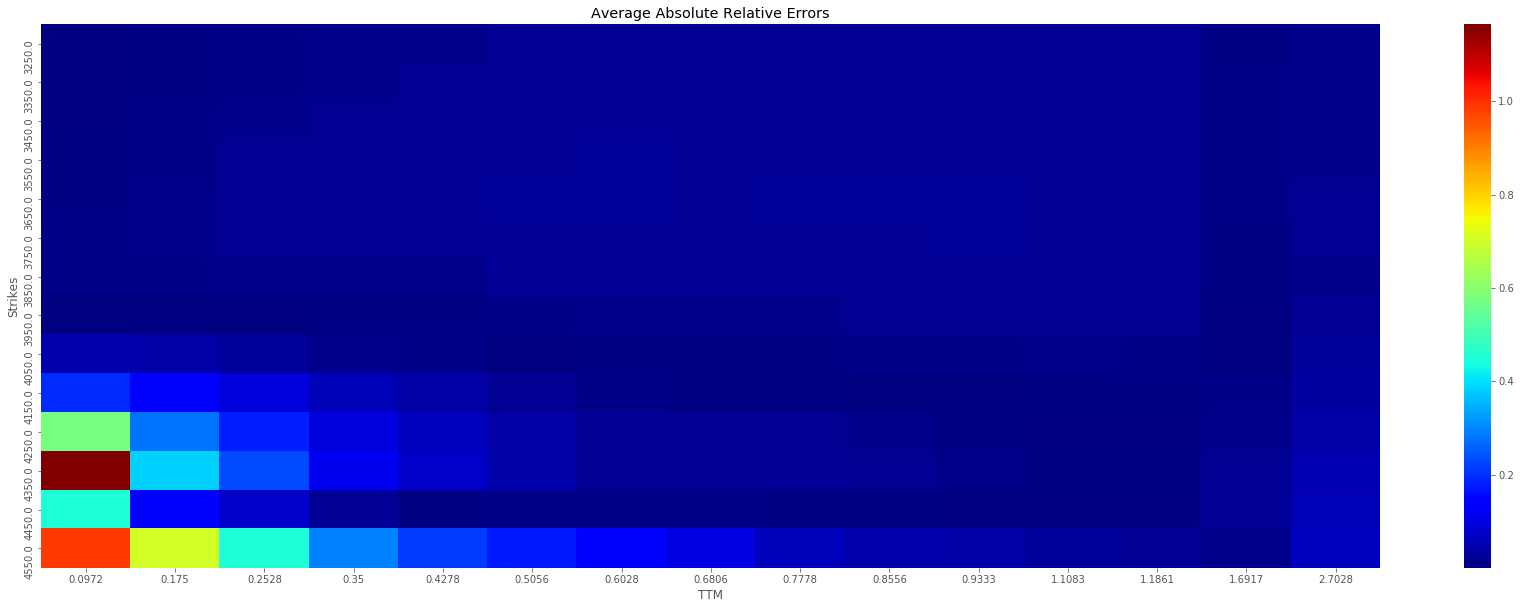

In [323]:
Errors1 = pd.DataFrame(aare_stk_ttm1.values(),index = aare_stk_ttm.keys())
Errors1.columns = L.Strikes.sort_values().unique()
Errors1.index = np.round(Errors1.index.values,4)
fig = plt.figure(figsize=(30,10))
sns.heatmap(Errors1.T, cmap="jet")
plt.title('Average Absolute Relative Errors')
plt.ylabel('Strikes')
plt.xlabel('TTM')
plt.show()

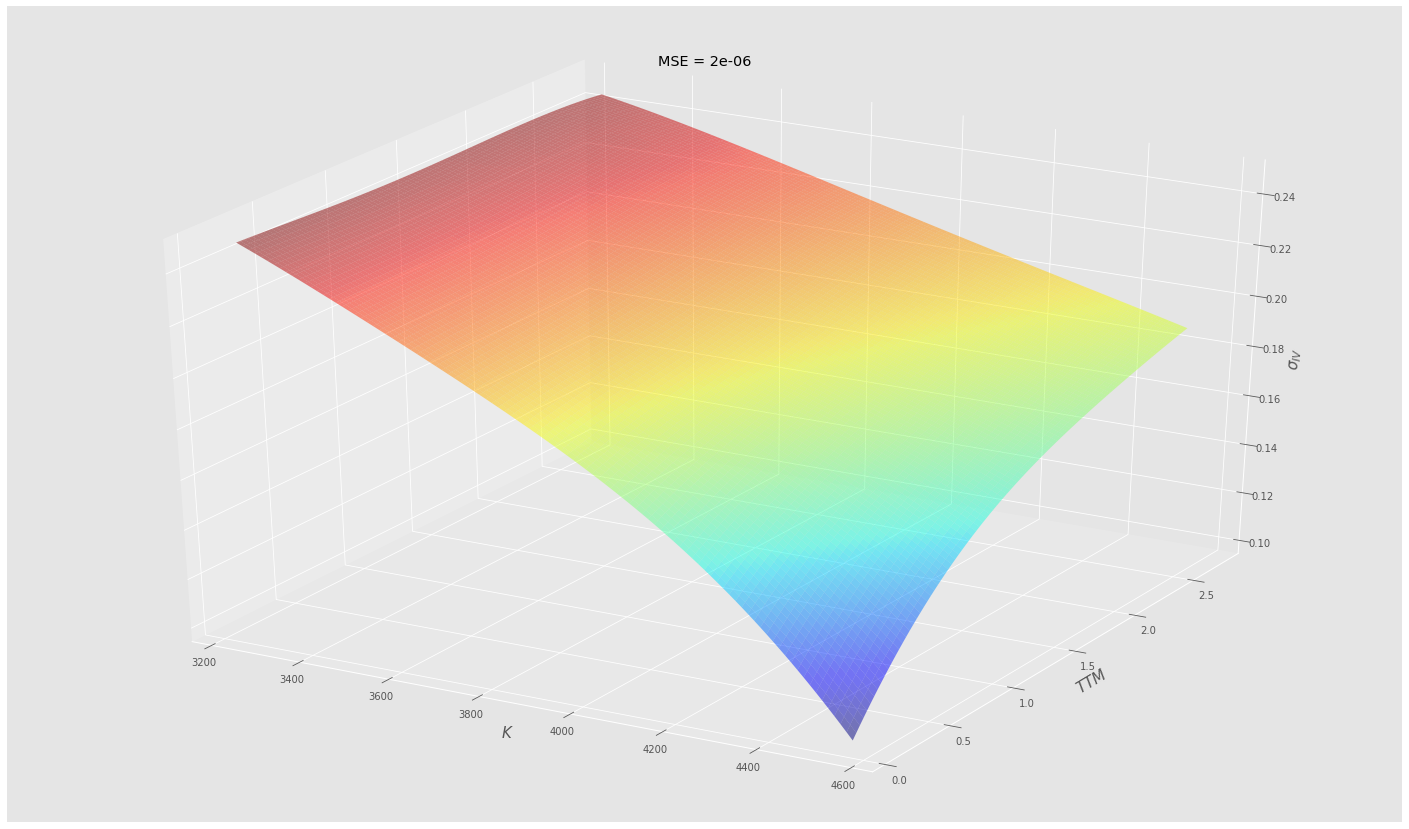

In [324]:
Prices,striks,imp_vol = Price_calib_iv_return(sl,r,Q)
TTMs = L['TTM'].values
Gaussian_Process_Interpolator(striks,TTMs,imp_vol,1)

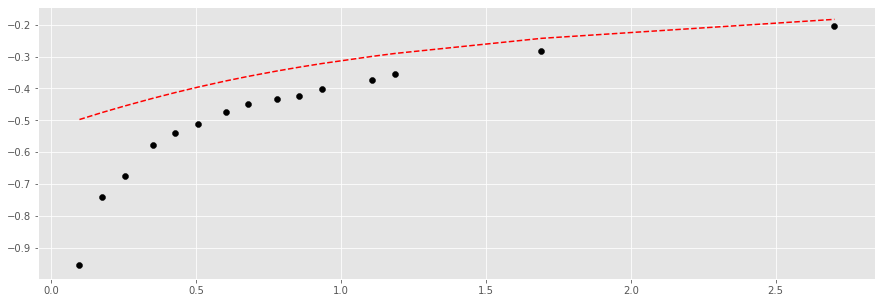

In [325]:
model2,obs = Price_calib_iv_return(sl,r,Q,True)
fig = plt.figure(figsize=(15,5))
plt.plot(L.TTM.unique(),model2,color = 'red',ls = '--')
plt.scatter(L.TTM.unique(),obs,color = 'black')
plt.show()

# Heston-Bates Model SVJ 

In [326]:
def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator1(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] -params[2]**2
        if pen_c < 1e-50:
            pen = 1e50
        #err =np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]r h in helpers]
        err =  pen * np.sum(spreads * np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)#len(helpers)
        if norm:
            return pen * err #pen * np.sum(spreads *np.abs([h.calibrationError() for h in heston_helpers4])**2/np.array(data).reshape(1,195)[0])/np.sum(spreads)
        else:
            return error
    return cost_function


def cost_function_generator2(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        err = np.sum(spreads * np.abs([h.calibrationError() for h in helpers]))**2  * 1/np.sum(spreads)#len(helpers)
        if pen_c < 1e-50 or params[0] < 1e-5 or params[1]<1e-5 or params[2]<1e-5 or params[4]<1e-5 or params[5]<1e-5 or params[7]<1e-5 or params[3]< -1 :
            pen = 1e50
        if norm:
            return pen * err#len(heston_helpers4)
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    IVMSE = np.sum(spreads* np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)#len(helpers)
    if detailed: print("-"*100)
    summary = "IVMSE  : %1.9f" % (IVMSE)
    print(summary)
    return IVMSE
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01,0.5,0.5,0.5)):
    theta, kappa, sigma, rho, v0,lambs,mu,sig_v = init_condition
    process = ql.BatesProcess (_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho,lambs,mu,sig_v)
    model = ql.BatesModel(process)
    engine = ql.BatesEngine(model) 
    return model, engine

def Constraint(x):
    theta, kappa, sigma, rho, v0,lambda_,mu,sig_v = x
    A = 2*kappa*theta - sigma**2 
    return A

const = {'type': 'ineq', 'fun': Constraint}
summary= []


In [327]:
%%time
model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
heston_helpers4, grid_data4 = setup_helpers(engine4, expiration_dates, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
initial_condition = (0.02, 0.2, 0.5, 0.1, 0.01,0.01,0.01,0.01)
bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10),(1e-5,1),(-1,1),(0.001,10)]
bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10),(1e-5,1),(-1,1),(0.001,10))
cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True)
sol = differential_evolution(cost_function, bounds=bounds,tol = 1e-9,maxiter = 50,popsize = 50,seed = 0)
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
sol = minimize(cost_function2,sol.x, bounds=bnds , tol =1e-9 , constraints = const,method = 'Nelder-Mead')
params_ = ql.Array(list(sol.x))
model4.setParams(params_)
theta_b, kappa_b, sigma_b, rho_b, v0_b , lambda_ ,mu,sigma_v = model4.params()
error = calibration_report(heston_helpers4, grid_data4)
summary.append(["Scipy DE1", error] + list(model4.params()))

IVMSE  : 0.000442503
CPU times: user 6min 50s, sys: 289 ms, total: 6min 50s
Wall time: 6min 50s


In [328]:
sl = np.array([rho_b,sigma_b,theta_b, kappa_b, v0_b , lambda_ ,mu,sigma_v])
df2,aare_stk_ttm2 = Return_df_Pricer(sl,risk_free_rate-dividend_rate,Q,error) #We evaluate the quality of the fit
df2

MSE  AARE(in %)       RMSE     IVMSE  DATA POINTS       RHO  \
Summary  669.304806    6.861501  25.870926  0.000443        210.0 -0.878127   

            SIGMA     THETA     KAPPA        V0    Lambda        Mu    Sigmav  
Summary  0.634993  0.042487  4.745131  0.013905  0.023799 -0.105863  0.088005

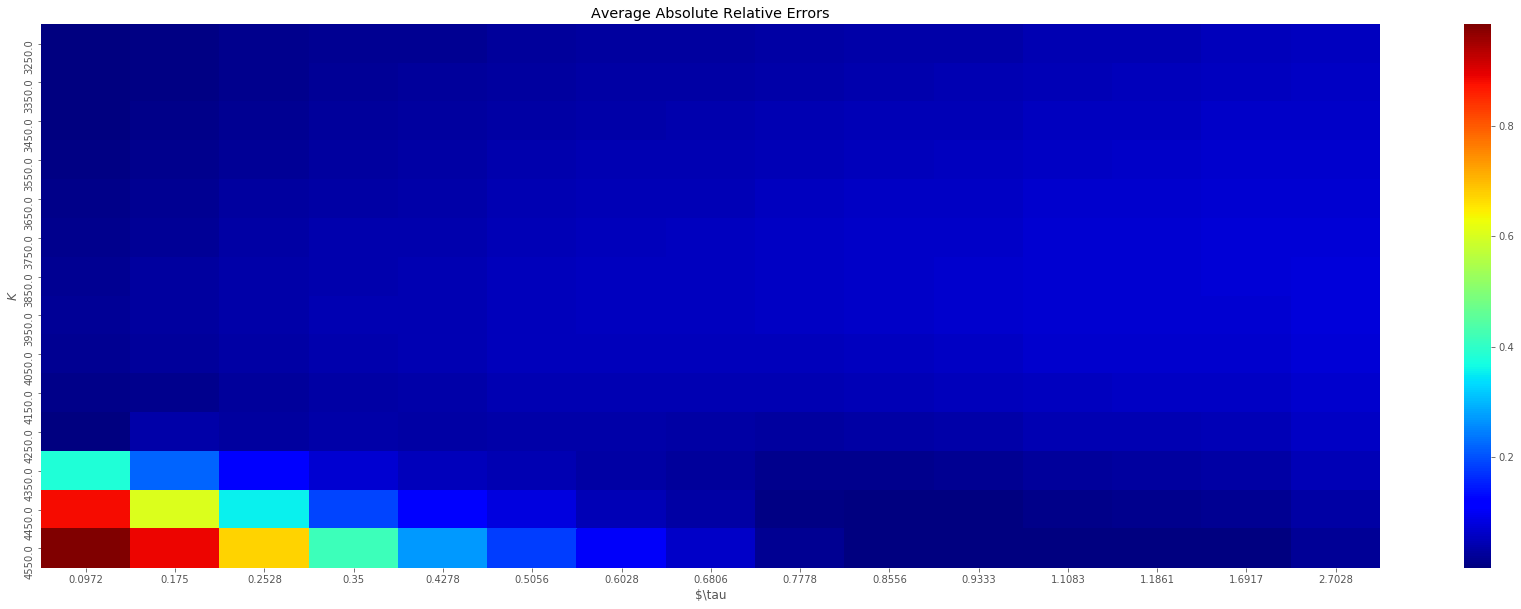

In [329]:
Errors2 = pd.DataFrame(aare_stk_ttm2.values(),index = aare_stk_ttm.keys())
Errors2.columns = L.Strikes.sort_values().unique()
Errors2.index = np.round(Errors2.index.values,4)
fig = plt.figure(figsize=(30,10))
sns.heatmap(Errors2.T, cmap="jet")
plt.title('Average Absolute Relative Errors')
plt.ylabel(r'$K$')
plt.xlabel(r'$\tau')
plt.show()

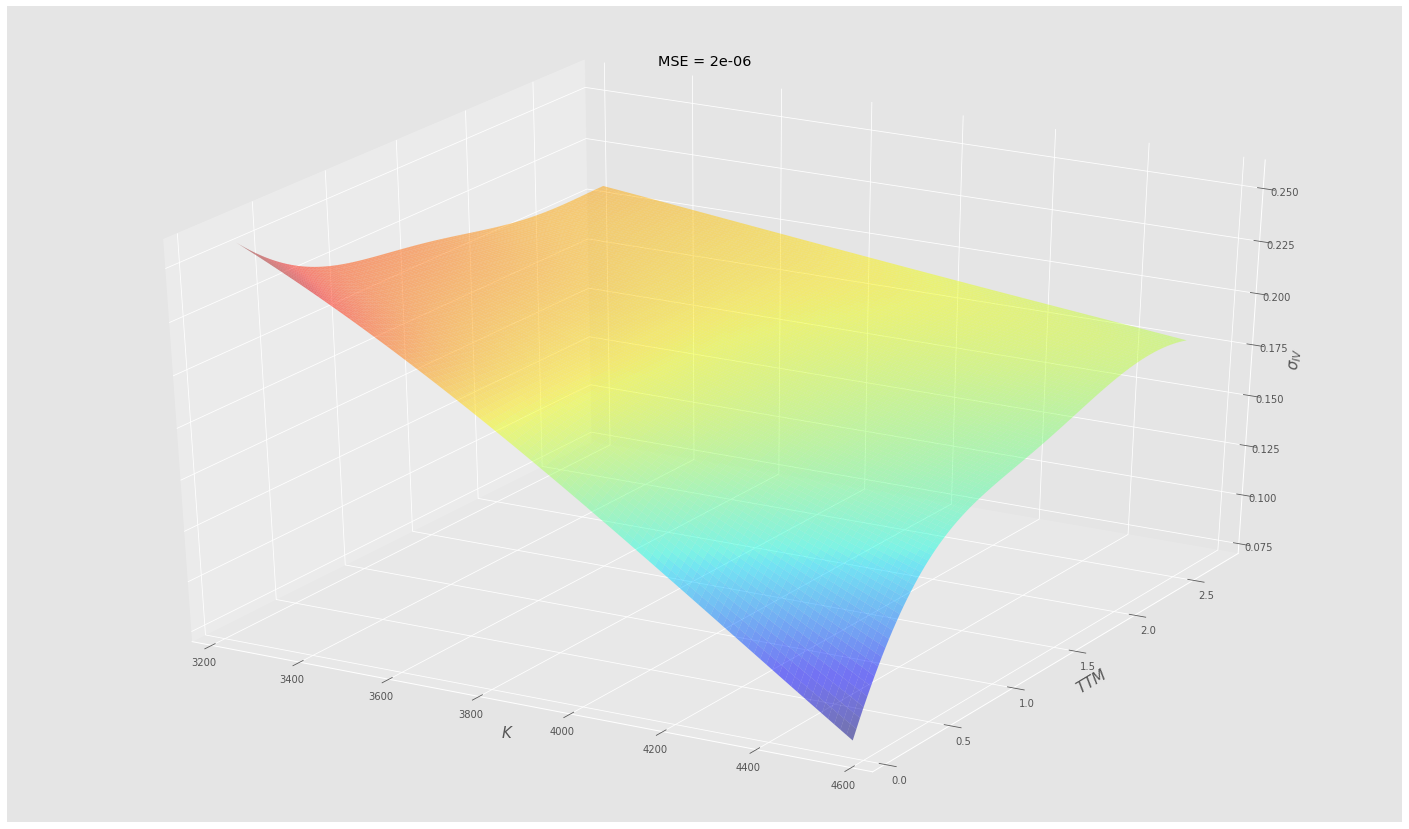

In [336]:
Prices,striks,imp_vol = Price_calib_iv_return(sl,r,Q)
TTMs = L['TTM'].values
Gaussian_Process_Interpolator(striks,TTMs,imp_vol,1)

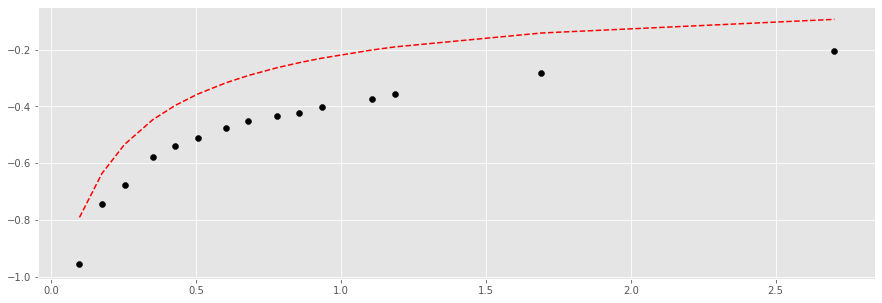

In [337]:
model3,obs = Price_calib_iv_return(sl,r,Q,True)
fig = plt.figure(figsize=(15,5))
plt.plot(L.TTM.unique(),model3,color = 'red',ls = '--')
plt.scatter(L.TTM.unique(),obs,color = 'black')
plt.show()

# SVI Parametrization

In [338]:
from scipy.optimize import minimize
import numpy as np


class svi_model:
    
    def __init__(self, data, init_adc, init_msigma, tol,strikes,T,IV,delta_k,Calendar_free = 'No'):
        
        self.init_msigma = init_msigma
        self.init_adc = init_adc
        self.tol = tol
        self.data = data
        self.T = T
        self.strikes = strikes
        self.IV = IV
        self.delta = delta_k
        self.Calendar_free = Calendar_free
        self.optimization()

    def forward_price(self):
        
        """
        Forward or Spot Price
        """
        
        f = self.data
        return f

    def outter_function(self, params):
       
        """
        Outter optimisor
        """
       
        m, sigma = params
        f,pen = self.forward_price(),1
        if sigma < 0 or m > max(np.log(self.strikes/f)) or m < min(np.log(self.strikes/f)):
            pen = 1e50
            sigma = max(0, sigma)
            #m = min(max(m,min(np.log(self.strikes/f))),max(np.log(self.strikes/f)))
        #print(m,np.min(np.log(self.strikes/f)),np.max(np.log(self.strikes/f)))
        adc_0 = self.init_adc
        adc_0 = [max(0,adc_0[0]),min(abs(adc_0[1]),abs(4*sigma)),min(max(adc_0[2],0),4*sigma)]

        def inner_fun(params):
           
            """
            Inner Optimisor
            """
            
            a, d, c = params
            error_sum = 0.0
            xi = np.log(self.strikes/f)
            y = (xi-m)/sigma
            z = np.sqrt(y**2+1)
            error_sum = np.sum(np.array(a + d * y + c * z -
                                        np.array(self.IV)**2*self.T) ** 2)
            return error_sum
        bnds = (
            (0, max(np.array(self.IV))), (-4*sigma, 4*sigma), (0, 4*sigma))
        b = np.array(bnds, float)
        cons = (
            {'type': 'ineq', 'fun': lambda x: x[2]-abs(x[1])},
            {'type': 'ineq', 'fun': lambda x: 4*sigma-x[2]-abs(x[1])},
            {'type': 'ineq', 'fun': lambda x: -np.abs(x[1]/x[2]) + 1},
            #{'type': 'ineq', 'fun': lambda x:  x[1]/x[2] + 1}
        )
        inner_res = minimize(inner_fun, adc_0, method='SLSQP', tol=1e-9,bounds = bnds,constraints = cons)
        
        a_star, d_star, c_star = inner_res.x
        self._a_star, self._d_star, self._c_star = inner_res.x

        sum = 0.0
        xi = np.log(self.strikes/f)
        y = (xi-m)/sigma
        z = np.sqrt(y**2+1)
        sum = pen * np.sum(np.array(a_star + d_star * y + c_star *
                              z - np.array(self.IV)**2*self.T) ** 2)
        return sum

    def optimization(self):
        
        """
        Calibrator
        """
        outter_res = minimize(
            self.outter_function, self.init_msigma, method='Nelder-Mead', tol=self.tol)
        m_star, sigma_star = outter_res.x
        self._m_star, self._sigma_star = outter_res.x
        #obj = outter_res.fun
        calibrated_params = [self._a_star, self._d_star,
                             self._c_star, m_star, sigma_star]
        return calibrated_params

    def svi_vol(self,delta = 0):
       
        """
        SVI Volatility curve
        """

        f = self.forward_price()
        xi = np.log(self.strikes/f) + delta
        y = (xi-self._m_star)/self._sigma_star
        z = np.sqrt(y**2+1)
        omega = np.array(self._a_star + self._d_star * y + self._c_star * z)
        sigma = np.sqrt(omega/self.T)
        #l = np.min(self.Dur_Condition())
        #if l < 0 :
        #    print('Arbitrage')
        sigma = np.sqrt(self.JW_params()/self.T)
        f = interp1d(self.strikes,sigma,kind='cubic')
        stk_n = np.linspace(self.strikes.min(),self.strikes.max(),300)
        sigma = f(stk_n)
        return sigma
    
    def svi_vol2(self,delta = 0):
        """
        Made to be used with The jump wing parametrisation
        
        """
        
        xi = np.log(self.strikes/self.data) + delta
        y = (xi-self._m_star)/self._sigma_star
        z = np.sqrt(y**2+1)
        omega = np.array(self._a_star + self._d_star * y + self._c_star * z)
        return omega 
    
    def JW_params(self):
        """
        JW Parameters 
        """
        a,sigma,b,m,p = self.reinitialise_params()
        self.v = (a + b *(-p * m + np.sqrt(m**2+sigma**2)))/self.T
        self.w = self.v * self.T
        self.u = 1/np.sqrt(self.w) * (b/2) * (-m /np.sqrt(m**2+sigma**2) + p)
        self.p2 = 1/np.sqrt(self.w) * b * ( 1 - p )
        if self.Calendar_free == 'Yes':
            self.c = 2 * self.u + self.p2#1/np.sqrt(self.w) * b * ( 1 + p )
            self.v2 = self.v * ( 4 * self.p2 * self.c)/((self.p2 + self.c)**2)#(a + b * sigma * np.sqrt(1 - p**2))/self.T 
        else :
            self.c = 1/np.sqrt(self.w) * b * ( 1 + p )
            self.v2 = (a + b * sigma * np.sqrt(1 - p**2))/self.T 
        
        self.Reconversion()
        #self.init_msigma = [v2,p2]
        #self.init_adc = [v ,p2 * c * b , p2 * b ]
        return self.svi_vol2(0)
    
    def second_optimisation(self):
        
        """
        Calibrator
        """
        outter_res = minimize(
            self.Block_optimised, self.init_msigma, method='Nelder-Mead', tol=self.tol)
        m_star, sigma_star = outter_res.x
        self._m_star, self._sigma_star = outter_res.x
        #obj = outter_res.fun
        calibrated_params = [self._a_star, self._d_star,
                             self._c_star, m_star, sigma_star]
        return calibrated_params
    
    def Block_optimised(self,params):
        u,p,v,c = params 
        c = 2 * u + p
        v2 = v * (4 * p * c)/(p+c)**2
        return c,v2
    
    def reinitialise_params(self):
        
        #Retrieving initial parameters 
        
        self._a_star = self._a_star
        self._sigma_star = self._sigma_star
        self._b_star = self._c_star/self._sigma_star
        self._m_star = self._m_star
        self._p_star = np.round(self._d_star/(self._c_star),2)
        return self._a_star,self._sigma_star,self._b_star,self._m_star,self._p_star
    
    def Reconversion(self):
        
        #Reconverting to used Params
        
        self._b_star = .5 * np.sqrt(self.w) * (self.c + self.p2)
        self._p_star = 1 - (self.p2 * np.sqrt(self.w))/self._b_star
        self.Beta_star = self._p_star - 2 * self.u * np.sqrt(self.w)/self._b_star
        self.alpha_star = np.sign(self.Beta_star) * np.sqrt(1/(self.Beta_star**2) - 1)
        self._m_star = ((self.v - self.v2)*self.T)/(self._b_star *(-self._p_star + np.sign(self.alpha_star)*np.sqrt(1+self.alpha_star**2)\
                                                                  - self.alpha_star * np.sqrt(1-self._p_star**2)))
        
        #self._a_star = self.v2 * self.T - self._b_star * self._sigma_star * np.sqrt(1-self._p_star**2)
        self._sigma_star = self._m_star * self.alpha_star#,(self.v * self.T - self._a_star)/(self._b_star))
        self._a_star = self.v2 * self.T - self._b_star * self._sigma_star * np.sqrt(1-self._p_star**2)
        self._d_star = self._p_star * self._b_star * self._sigma_star
        self._c_star = self._b_star * self._sigma_star        
        
    def dminus(self,x):
        vsqrt = np.sqrt(x/self.T)
        y = np.log(self.strikes/self.data)
        return -y/vsqrt - 0.5*vsqrt
        
    def Dur_Condition(self):
        
        #Fokker-Plan Condition
        
        
        dk = (np.max(np.log(self.strikes/self.data))-np.min(np.log(self.strikes/self.data)))/len(self.strikes)
        k = np.log(self.strikes/self.data)
        #if self.Calendar_free == 'Yes': 
        self.svi_vol()
        A,A_ = self.svi_vol2(dk),self.svi_vol2(2*dk)
        B,B_ = self.svi_vol2(-dk),self.svi_vol2(-2*dk)
        dSvi = (A - B) / (2 * dk)
        Svi = self.svi_vol2()
        ddSvi = (A_ - 2 * Svi  + B_ )/(2 * dk**2)
        dm = self.dminus(Svi)
        g = ((1 - k * dSvi /(2 * Svi))**2 - (1/4)*(1/Svi + 1/4) * (dSvi**2)  + ddSvi/2)
        f = interp1d(self.strikes,g,kind='cubic')
        stk_n = np.linspace(self.strikes.min(),self.strikes.max(),300)
        g = f(stk_n)
        return g
        
        

In [339]:
#Initial_params
def initialist(parameters,strikes,S0):
    a = 0 + (parameters[2]/2)*(1-parameters[0]**2)
    b = parameters[1] * parameters[2]/2
    sigma = np.sqrt(1-parameters[0]**2)/parameters[1]
    c = b*sigma
    d = parameters[0] * b * sigma
    m = - parameters[0]/parameters[1]
    return a,d,c,m,sigma


init = initialist(sl,strikes,S0)
init_1 = init[:3]
init_2 = init[3:]
print(init_1,init_2)

(0.004862536248304771, -0.008924906127638127, 0.010163572607761035) (1.3828917692190559, 0.7534377683241242)


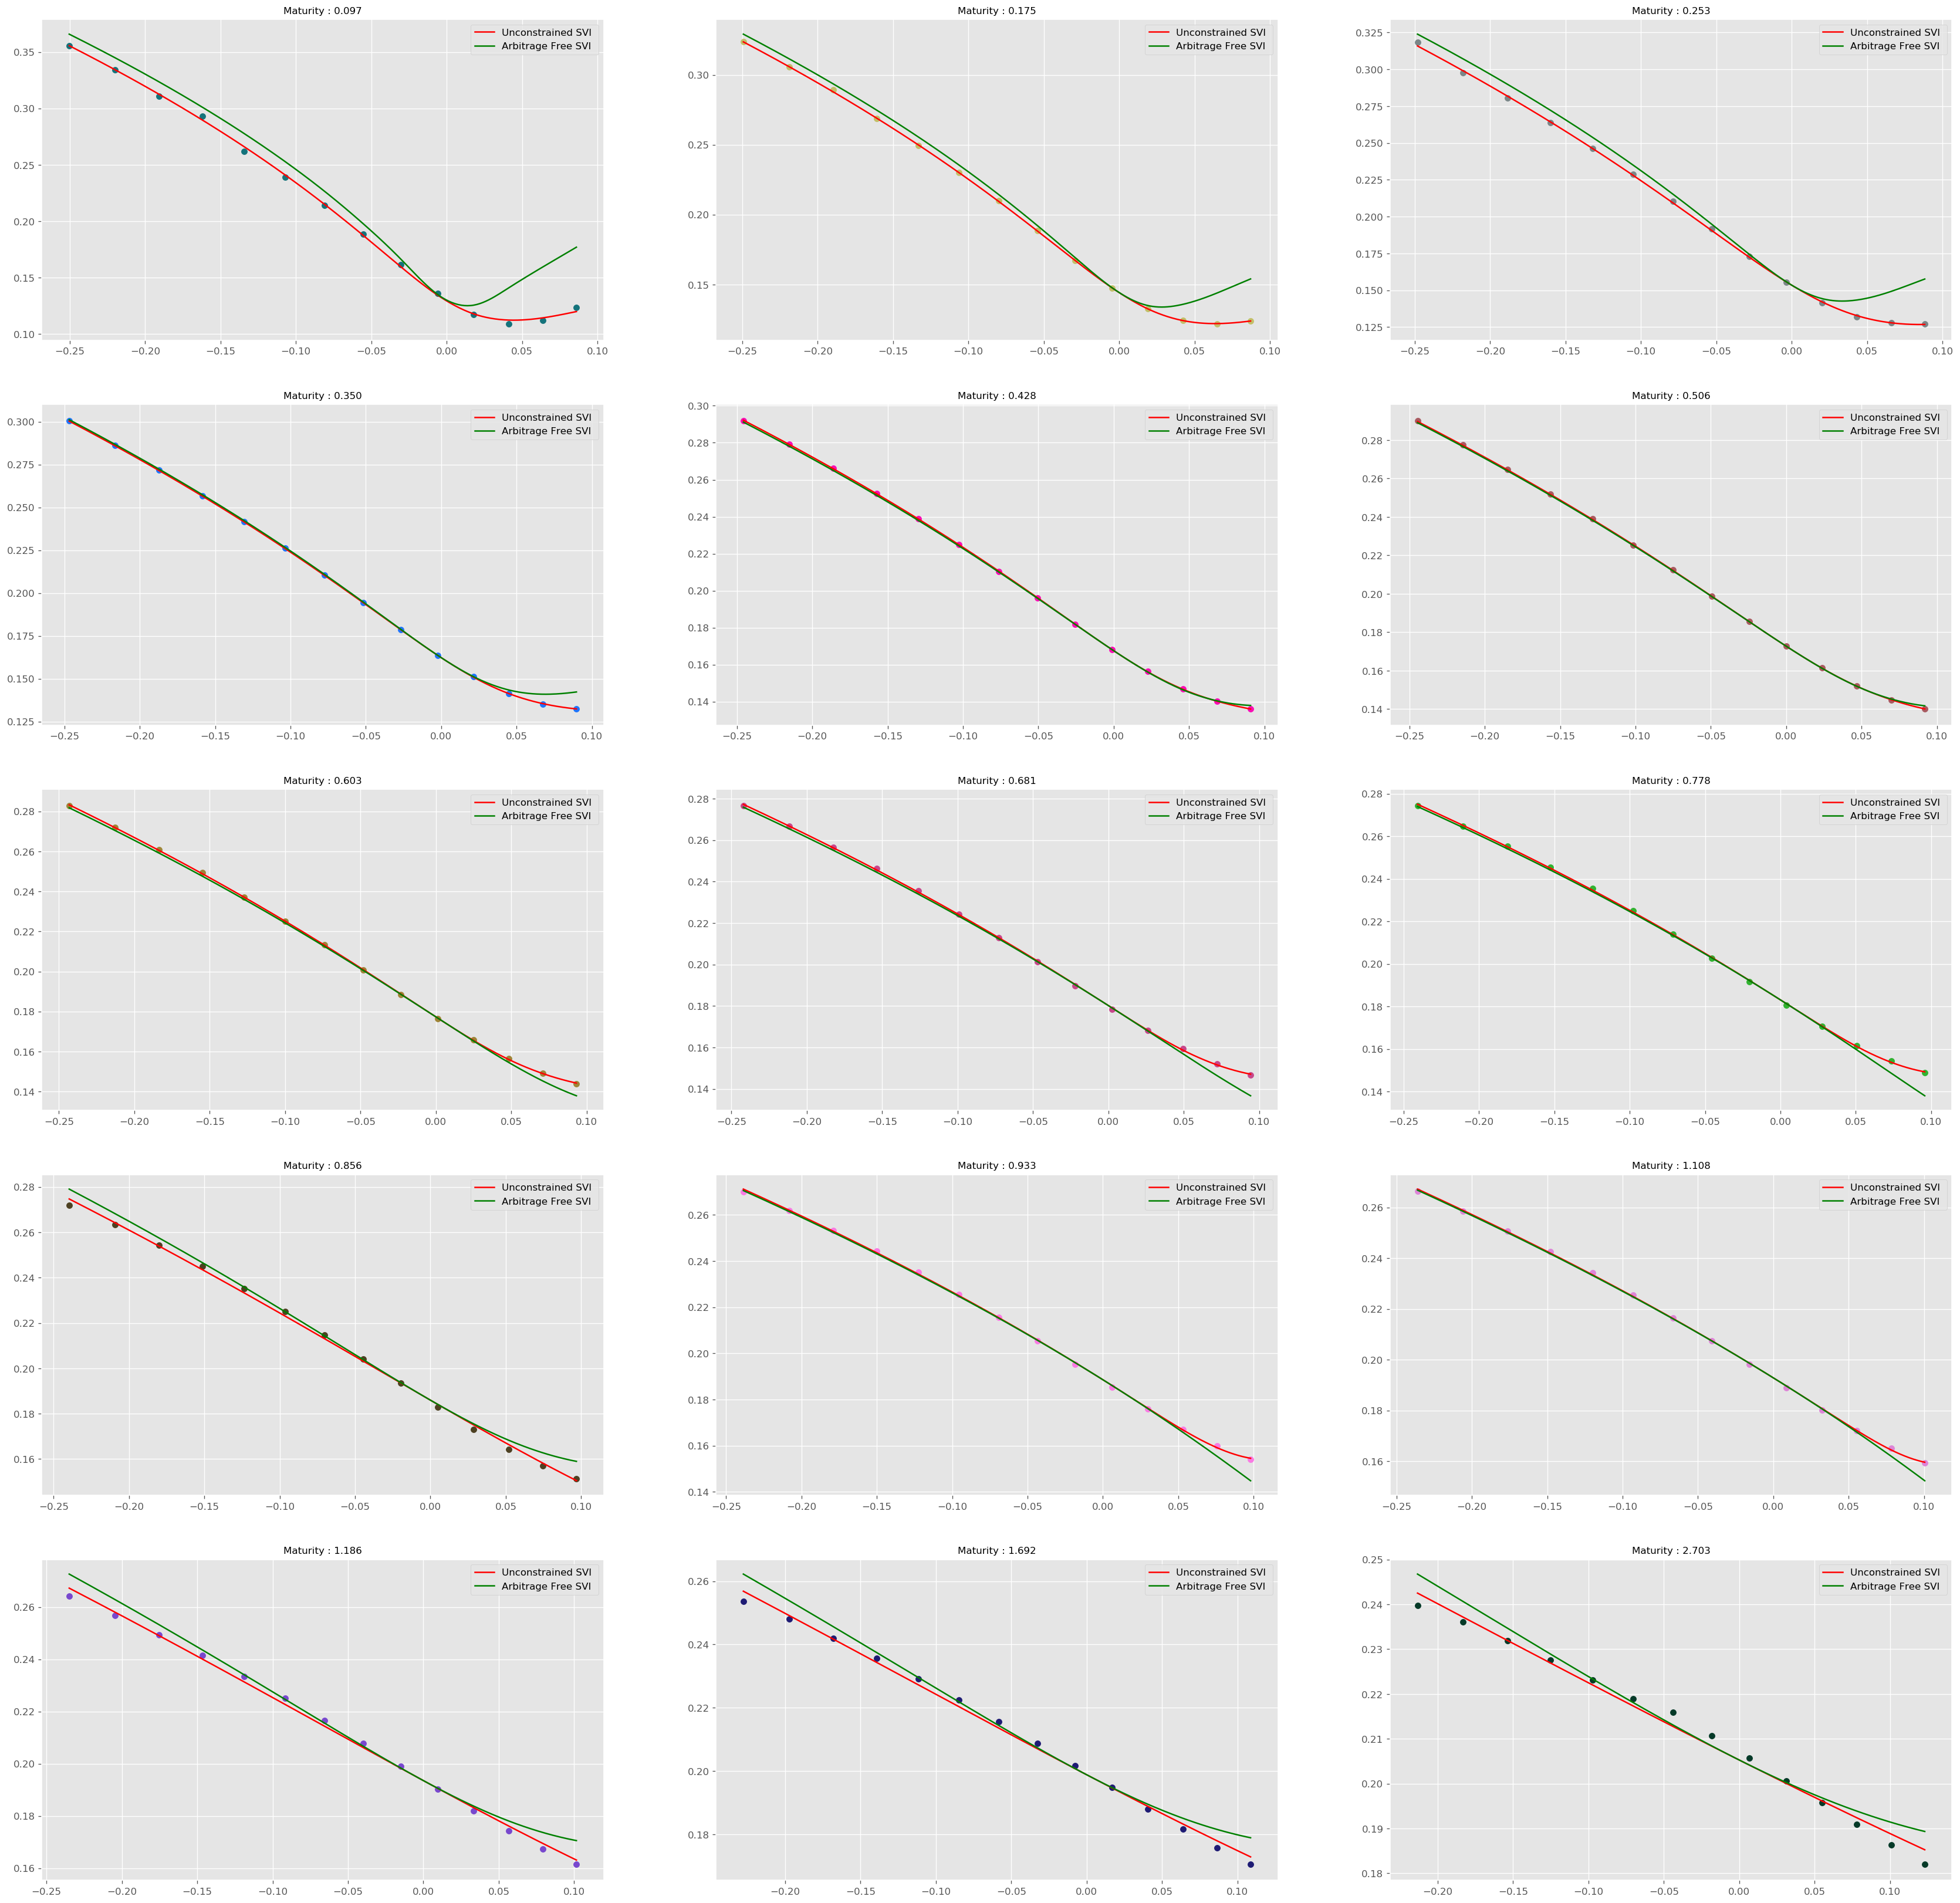

In [393]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(35,35))
fig.canvas.set_window_title('SVI Parametrization')
strikes = np.array(strikes)
stk_n = np.linspace(strikes.min(),strikes.max(),300)
S_t = S0*np.exp(L.TTM.unique()*(risk_free_rate-dividend_rate))
for i, ax in enumerate(axes.flatten()): 
    t = L.TTM.unique()[i]
    IV = Q.loc[t]['Implied Volatility'].values
    data1 = svi_model(S_t[i],init_1,init_2,1e-9,strikes,t,IV,0,'No').svi_vol(0)
    data2 = svi_model(S_t[i],init_1,init_2,1e-9,strikes,t,IV,0,'Yes').svi_vol(0)
    ax.plot(np.log(stk_n/S_t[i]),data1,color = 'red',label = 'Unconstrained SVI ')
    ax.plot(np.log(stk_n/S_t[i]),data2,color = 'green',label = 'Arbitrage Free SVI ')
    ax.plot()
    ax.legend(fontsize = 10)
    ax.scatter(np.log(strikes/S_t[i]),IV,color = np.random.rand(3,))
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)

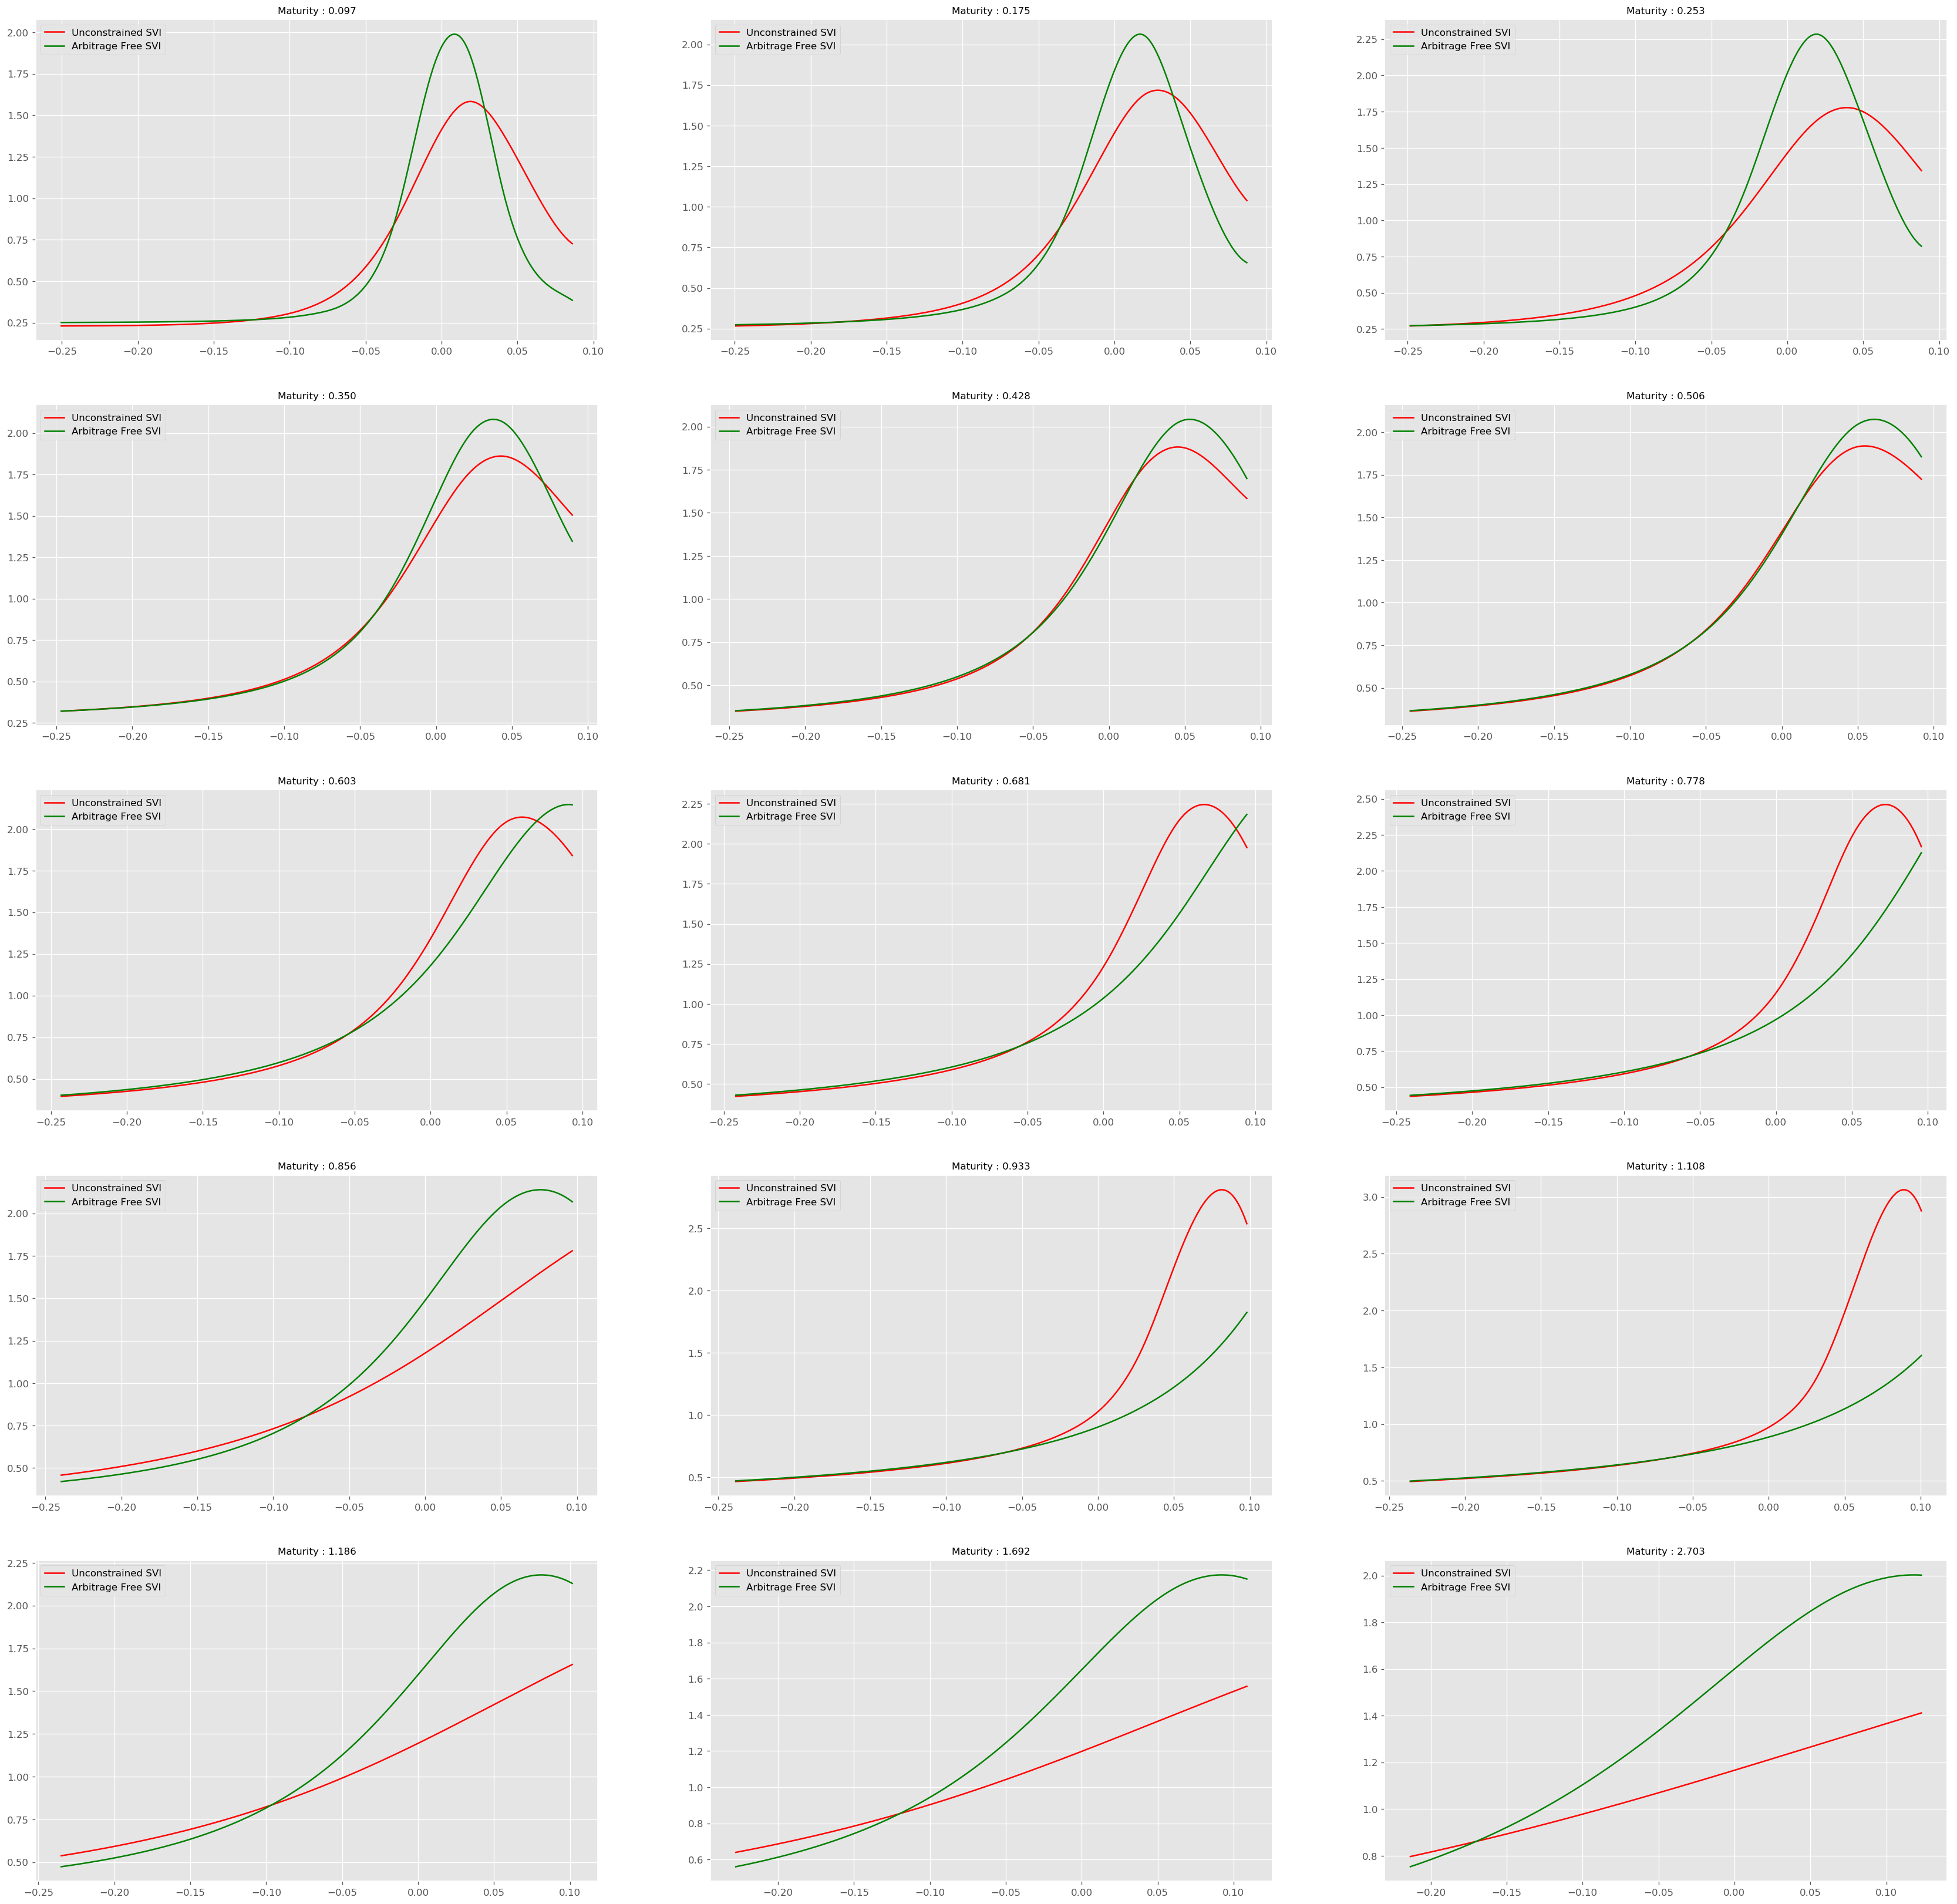

In [395]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(35,35))
fig.canvas.set_window_title('SVI Parametrization')
strikes = np.array(strikes)
for i, ax in enumerate(axes.flatten()): 
    t = L.TTM.unique()[i]
    IV = Q.loc[t]['Implied Volatility'].values
    g1 = svi_model(S_t[i],init_1,init_2,1e-9,strikes,t,IV,0).Dur_Condition()
    g2 = svi_model(S_t[i],init_1,init_2,1e-9,strikes,t,IV,0,'Yes').Dur_Condition()
    ax.plot(np.log(stk_n/S_t[i]),g1,color = 'red',label = 'Unconstrained SVI' )
    ax.plot(np.log(stk_n/S_t[i]),g2,color = 'green', label = 'Arbitrage Free SVI')
    ax.legend(fontsize = 10)
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)

# SSVI

In [342]:
def phi(theta, params):
    gamma, eta, sigma, rho = params
    return eta / theta**gamma

def SSVI(x, t, params):
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    if  constraint3(params,t) > 0 or constraint4(params,t) > 0 or constraint6(params) < 0 : #or params[0] < 0 or params[1] < 0
        return 1e50
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, t, params):
    ## First derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, t, params):
    ## Second derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, t, params):
    ## First derivative with respect to t, by central difference
    eps = 0.0001
    return (SSVI(x,t+eps,params) - SSVI(x,t-eps,params))/(2.*eps)

def g(x, t, params):
    w = SSVI(x,t,params)
    w1 = SSVI1(x,t,params)
    w2 = SSVI2(x,t,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus(x, t, params):
    vsqrt = np.sqrt(SSVI(x,t,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, t, params):
    dm = dminus(x,t,params)
    return g(x,t,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,params))

def SSVI_LocalVarg(x, t, params):
    ## Compute the equivalent SSVI local variance
    #if constraint1(params,t) > 0 or constraint2(params,t) < 0 or constraint3(params,t) > 0 \
    #    or constraint4(params,t) > 0 or constraint5(params,t) < 0 or params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < -1\
    #    or params[0] > 1 or params[1] > 1 or params[2] > 1 or params[3] > 1:
    #    return 1e50
    return SSVIt(x,t,params) / g(x,t,params)

def constraint1(x,args):
    t = args
    theta = x[2]*x[2]*t
    ret = -(theta + np.sqrt(theta) * np.sqrt(1/252)\
    * phi(theta + np.sqrt(theta) * np.sqrt(1/252),x) - (theta - np.sqrt(theta) * np.sqrt(1/252)\
    * phi(theta - np.sqrt(theta) * np.sqrt(1/252),x)))/(2 *np.sqrt(theta) * np.sqrt(1/252)) - \
    (x[3])**-1 * (1 + (1 + np.sqrt(1 - x[3]**2))) * phi(theta,x)
    return ret - 1e-3

def constraint2(x,args):
    t = args
    theta = x[2]*x[2]*t
    ret = (theta + np.sqrt(theta) * np.sqrt(1/252)\
    * phi(theta + np.sqrt(theta) * np.sqrt(1/252),x) - (theta - np.sqrt(theta) * np.sqrt(1/252)\
    * phi(theta - np.sqrt(theta) * np.sqrt(1/252),x)))/(2 *np.sqrt(theta) * np.sqrt(1/252))
    return ret - 1e-3

def constraint3(x,args):
    t = args
    theta = x[2]*x[2]*t
    ret = theta * phi(theta,x) * (1 - np.abs(x[3]))
    return ret - 4 - 1e-3

def constraint4(x,args):
    t = args
    theta = x[2]*x[2]*t
    ret = theta * phi(theta,x)**2 * (1 - np.abs(x[3]))
    return ret - 4 - 1e-3

def constraint5(x,args):
    t = args
    theta_p_d_t = (x[2]*x[2]*(t+1/252) - x[2]*x[2]*(t-1/252))/(2/252) - 1e-30
    return theta_p_d_t

def constraint6(x):
    return x[0] - 0.25*(1.+np.abs(x[3]))

In [343]:
sigma, gamma,eta, rho = 0.2, 0.8, 0.3,-0.5
xx, TT = np.log(Q.droplevel(0).index.unique()/S0), Q.droplevel(1).index.unique()

print("Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, eta, sigma, rho

localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]
VarianceSSVI = np.sqrt([[SSVI(x, t, params)/t for x in xx] for t in TT])

Consistency check to avoid static arbitrage:  True


In [379]:
%%time
from scipy.optimize import basinhopping,differential_evolution,minimize


pm1,pm2,pm3,pm4,err = [],[],[],[],[]
spreads = np.abs(1/(L.groupby(['TTM','Strikes']).mean().Spread.values))
def Calibrator(params,args):
    xx,TT,IV,spreads,strikes,S0= args
    SSVI_ = np.sqrt(np.array([[SSVI(x-drift*t, t, params)/t for x in xx] for t in TT]).reshape(len(TT),len(xx)))
    IV = IV.reshape(len(TT),len(xx))
    spreads = spreads.reshape(len(TT),len(xx))
    least_square = np.sum(spreads * np.abs(SSVI_ - IV)**2)/(np.sum(spreads))
    if np.isnan(least_square) :
        least_square = 1e50
    return least_square


bnds = ((1e-5,10),(0,10),(1e-5,10),(-1,1))
sigma, gamma, eta, rho = 0.5, 0.6, 0.3, -0.9
x0 = [gamma, eta, sigma, rho]
args = [xx,TT,Q['Implied Volatility'].values,spreads,strikes,S0]
res = differential_evolution(Calibrator,bounds = bnds, maxiter = 100, args = [args] ,\
                             tol = 1e-9 ,seed = 0,popsize = 100,polish = True,workers = -1 )
#res = minimize(Calibrator,res.x,tol =1e-9,args = args,method = 'Nelder-Mead',options = {'disp':True},bounds = bnds)

CPU times: user 3.14 s, sys: 184 ms, total: 3.32 s
Wall time: 30.4 s


In [380]:
def Evaluator(params,args):
    xx,t,IV,spreads,strikes,S0= args
    SSVI_ = np.sqrt(np.array([[SSVI(x-drift*t, t, x2)/t for x in xx] for x2 in params]).reshape(len(params),len(xx)))
    least_square = np.array([np.sum(spreads * np.abs(x - IV)**2)/(np.sum(spreads)) for x in SSVI_]).reshape(20,20,20)
    return least_square

In [381]:
gamma = np.linspace(0.5,.9,20);eta = np.linspace(0.5,.9,20)
rho_ = np.linspace(-1,0.894737,20);sigma = np.linspace(0.05,1,20)
args = [xx,TT[0],Q['Implied Volatility'].loc[TT[0]].values,Q.Spread.loc[TT[0]].values,strikes,S0]
params1 = np.array([[[[x,y,0.547705,m] for x in gamma] for y in eta] for m in rho_ ]).reshape(-1,4)
params2 = np.array([[[[0.533147,m,x,y] for x in sigma] for y in rho_] for m in eta]).reshape(-1,4)
err3 = Evaluator(params1,args)
err2 = Evaluator(params2,args)

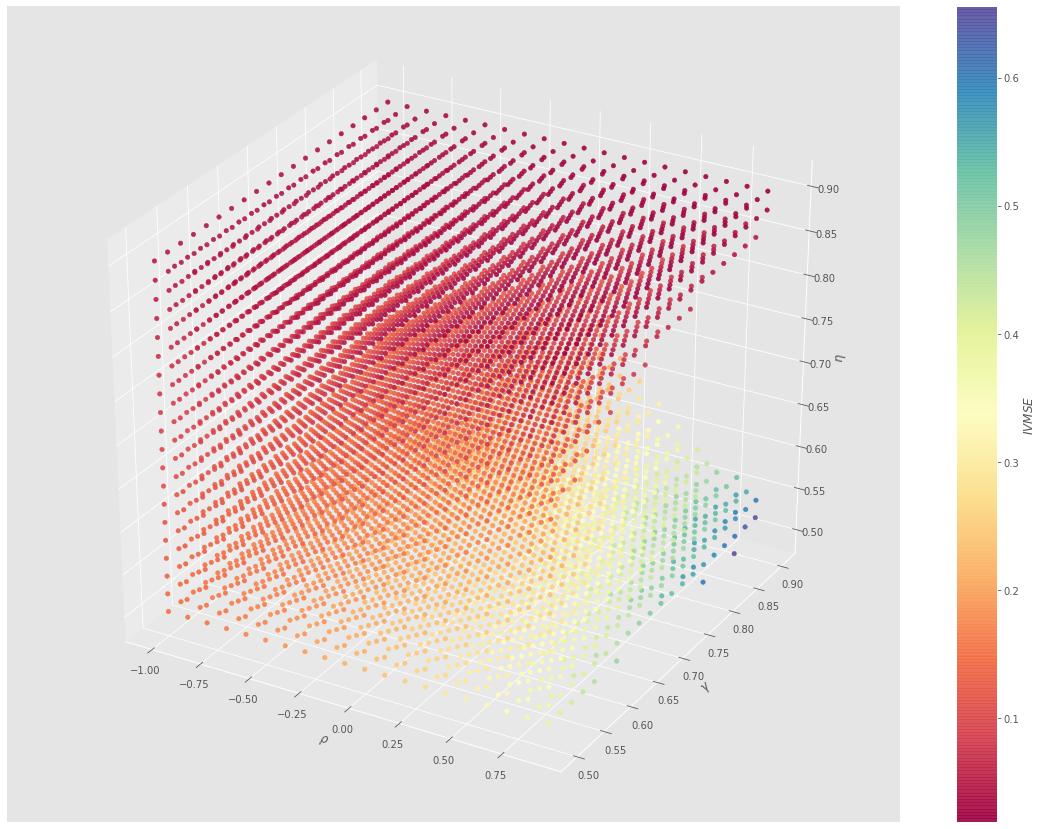

In [382]:
err3[err3 > 1e3] = np.nan
imp_err_ = err3
xxx_, yyy_,zzz_ = np.meshgrid(gamma,eta,rho_)
fig = plt.figure(figsize=(20,15))
ax = fig.gca(projection='3d')
img = ax.scatter(zzz_.ravel(),xxx_.ravel(),yyy_.ravel(),c = imp_err_.ravel(), alpha=0.9,cmap = plt.cm.Spectral)
fig.colorbar(img,label=r'$IVMSE$')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\gamma$')
ax.set_zlabel(r'$\eta$')
plt.show()

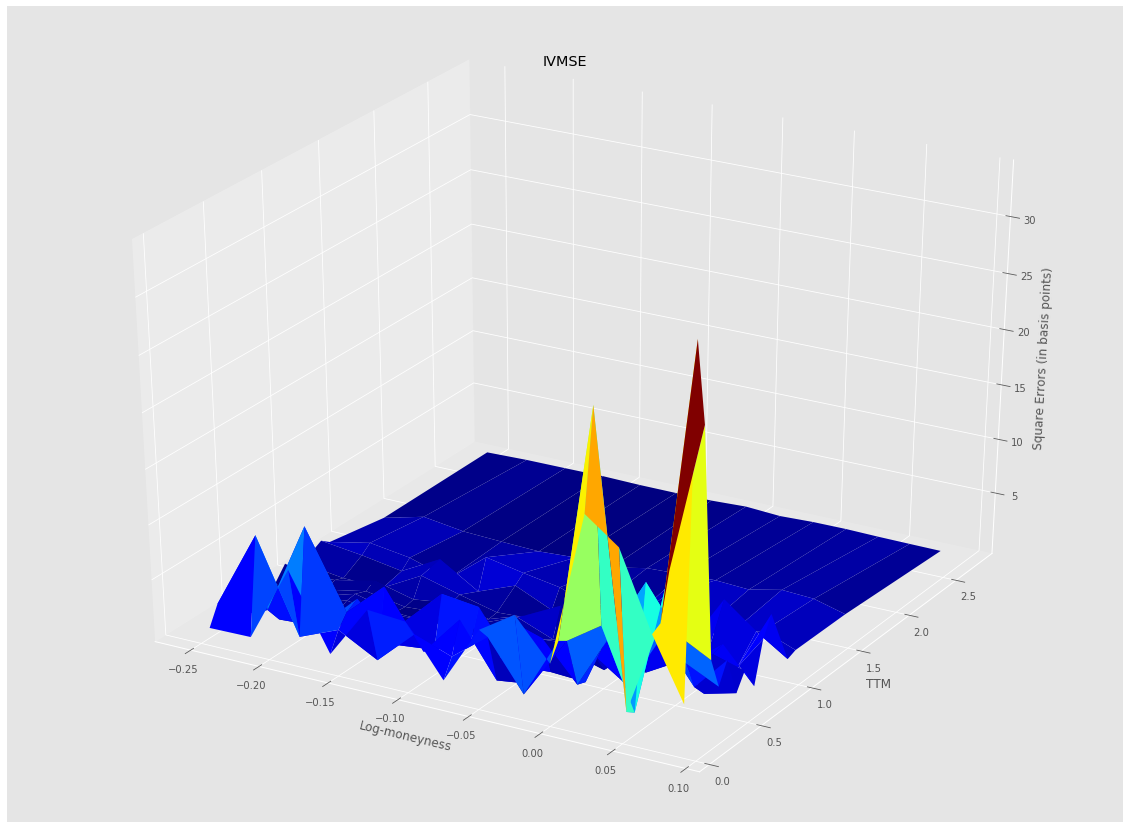

In [391]:
Errors = (1/np.sum(spreads)) * np.abs(spreads*(np.sqrt([SSVI(x-drift*t, t, res.x)/t for x in xx for t in TT])\
                                               - L['Implied Volatility'].values)**2) * 1e5
vol_error = pd.DataFrame(Errors.reshape(15,14),index = TT ,columns = xx )
xxx, TTT = np.meshgrid(xx, TT)
fig = plt.figure(figsize=(20,15))
ax = fig.gca(projection='3d')
ax.plot_surface(xxx, TTT, vol_error.values, rstride=1, cstride=1, linewidth=0,cmap = plt.cm.jet)
ax.set_xlabel('Log-moneyness')
ax.set_ylabel('TTM')
ax.set_zlabel('Square Errors (in basis points)')
plt.title('IVMSE')
plt.show()

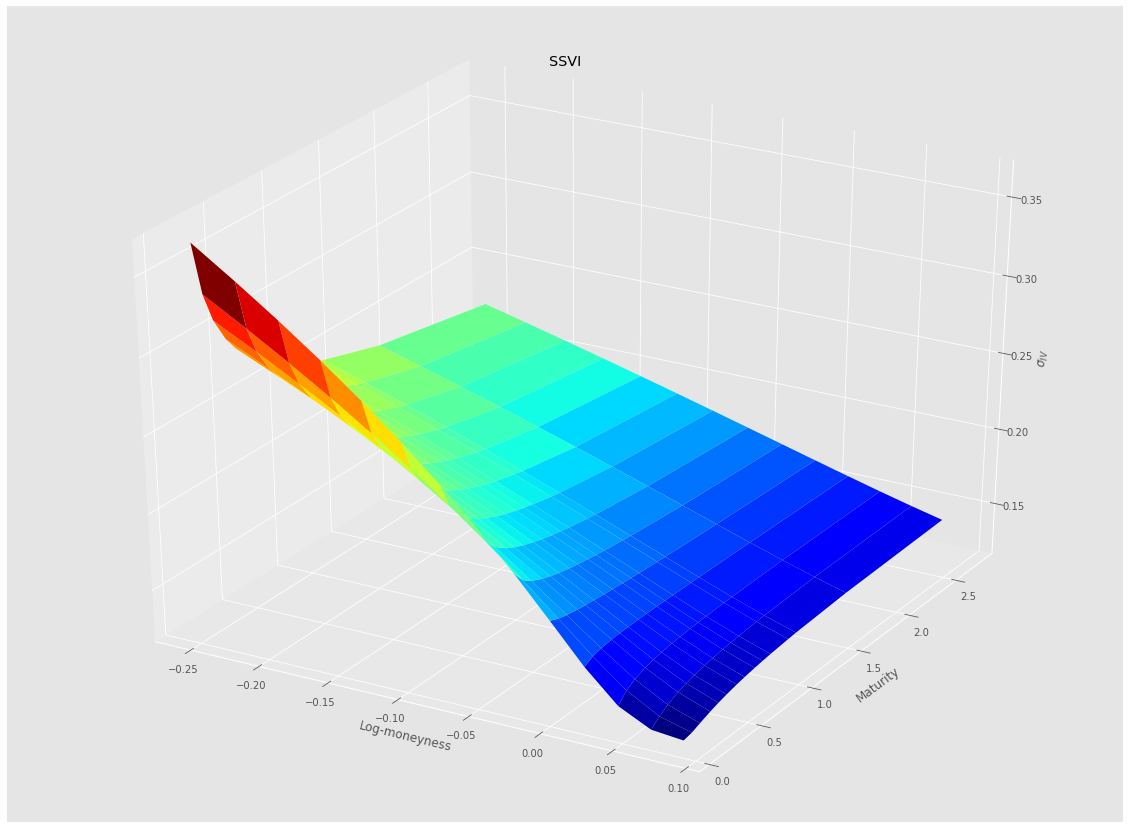

In [389]:
SSVI_ = ([[SSVI(x-drift*t, t, res.x)/t for x in xx] for t in TT])
fig = plt.figure(figsize=(20,15))
ax = fig.gca(projection='3d')
VSSVI = np.sqrt(SSVI_)
ax.plot_surface(xxx, TTT, VSSVI, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel(r"$\sigma_{IV}$")
ax.set_title("SSVI")
plt.show()

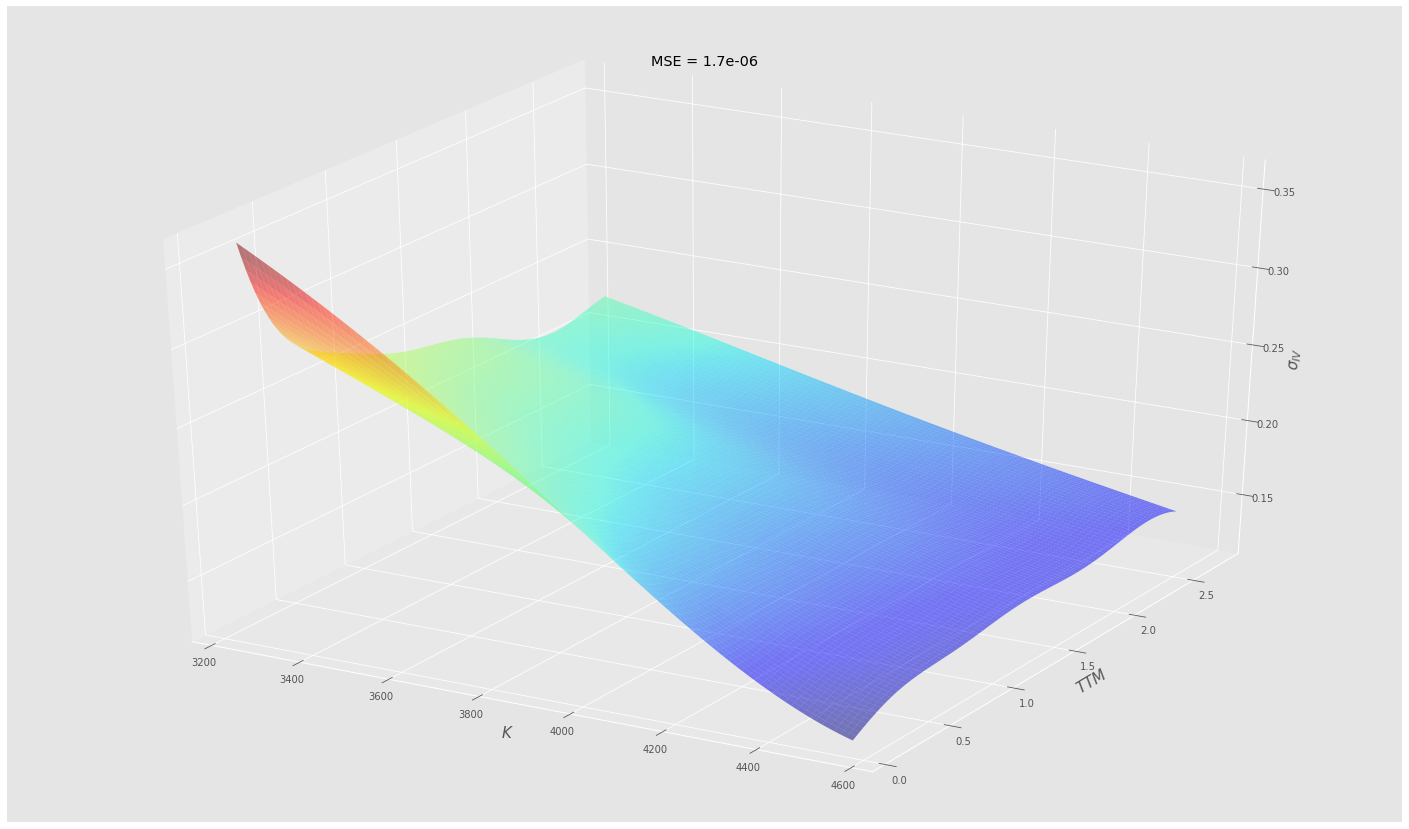

In [385]:
stk = np.array(Q.droplevel(0).index)
lvol = np.array(np.sqrt(SSVI_)).reshape(1,len(stk))
TTMs = np.array(Q.droplevel(1).index)
Gaussian_Process_Interpolator(stk,TTMs,lvol,1)

In [386]:
def Return_df_SSVI(x,S,r,Q,ivmse,SSVI):
    mse = 0
    rmse = 0
    aare = 0
    errors_stk_ttm = {}
    for l,i in enumerate(Q.unstack().index):
        prices, strikes, spreads = Q.loc[i].iloc[:,-2].values,Q.loc[i].index.values,1/(Q.loc[i].iloc[:,-3].values)
        prices_calib = np.array([_price_(S, K, i, r, SSVI[l,j]) for j,K in enumerate(strikes) ])
        mse = mse + np.sum((prices_calib - prices)**2)
        aare = aare + np.sum(np.abs(prices_calib - prices)/prices)
        errors_stk_ttm[i] = np.abs(prices_calib - prices)/prices 
    mse = mse/len(Q)
    rmse = np.sqrt(mse)
    aare = aare/len(Q) * 100
    df = pd.DataFrame([mse,aare,rmse,ivmse,int(len(Q))]+x.tolist(),index = ['MSE','AARE(in %)','RMSE','IVMSE','N',r'$\sigma$',r'$\gamma$',r'$\eta$',r'$\rho$'],columns = ['Summary']).T
    return df,errors_stk_ttm
df4,er4 = Return_df_SSVI(res.x,S0,r,Q,res.fun,np.sqrt(SSVI_))
df4 

MSE  AARE(in %)       RMSE     IVMSE      N  $\sigma$  \
Summary  852.393474    7.837929  29.195778  0.000213  210.0  0.428105   

         $\gamma$    $\eta$    $\rho$  
Summary  1.404365  0.172305 -0.712335

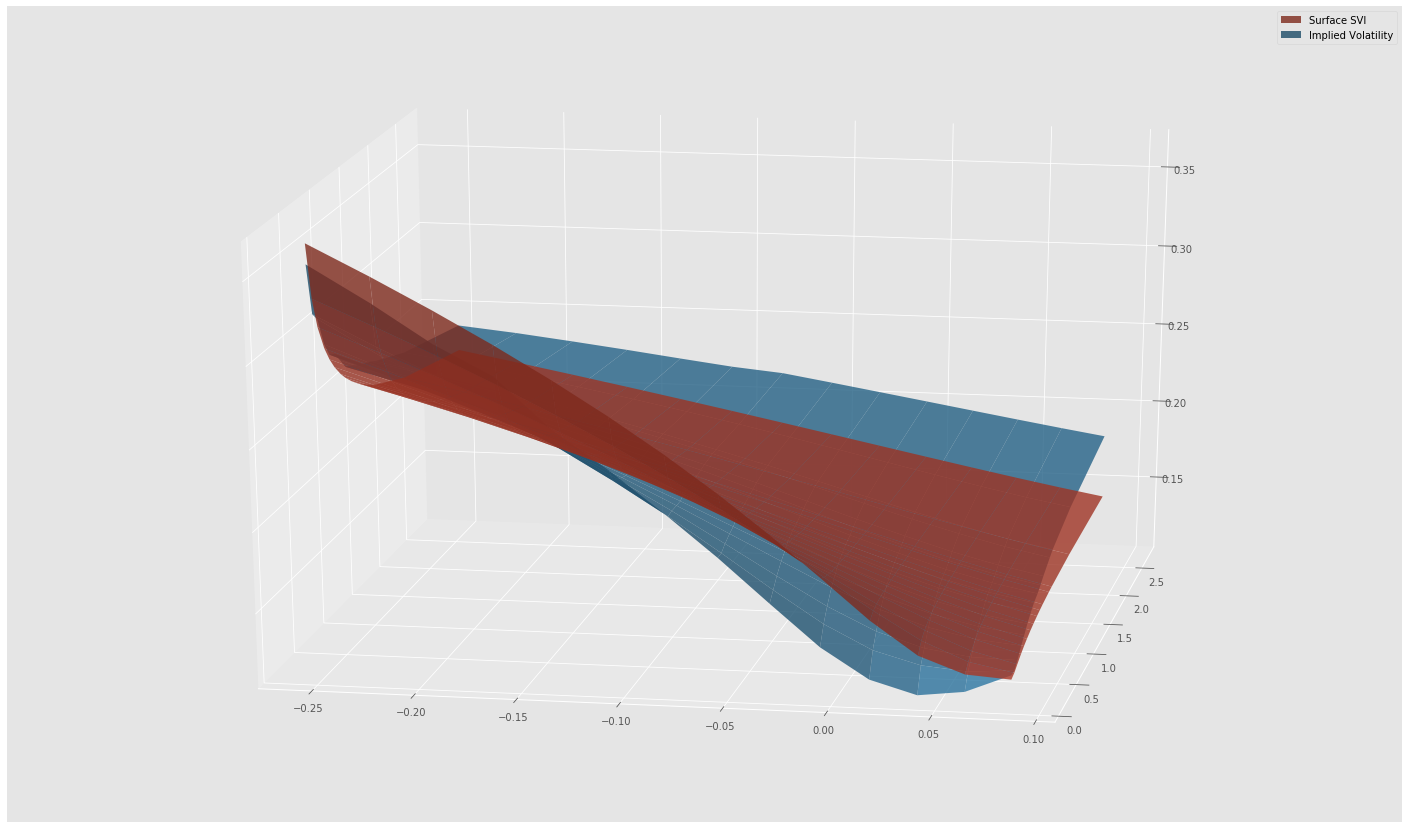

In [387]:
fig = plt.figure(figsize=(25, 15))
ax = fig.gca(projection='3d')
c1 = ax.plot_surface(xxx, TTT, VSSVI, rstride=1, cstride=1, linewidth=0,alpha=0.8,\
                     label = 'Surface SVI')


c1._facecolors2d=c1._facecolors3d
c1._edgecolors2d=c1._edgecolors3d
c3 = ax.plot_surface(xxx, TTT,Q['Implied Volatility'].values.reshape(15,14), rstride=1, cstride=1,\
                     linewidth=0.1, antialiased=True,label='Implied Volatility',alpha=0.8)
c3._facecolors2d = c3._facecolors3d
c3._edgecolors2d = c3._edgecolors3d
ax.view_init(elev=20, azim=-80)
ax.legend()
plt.show()

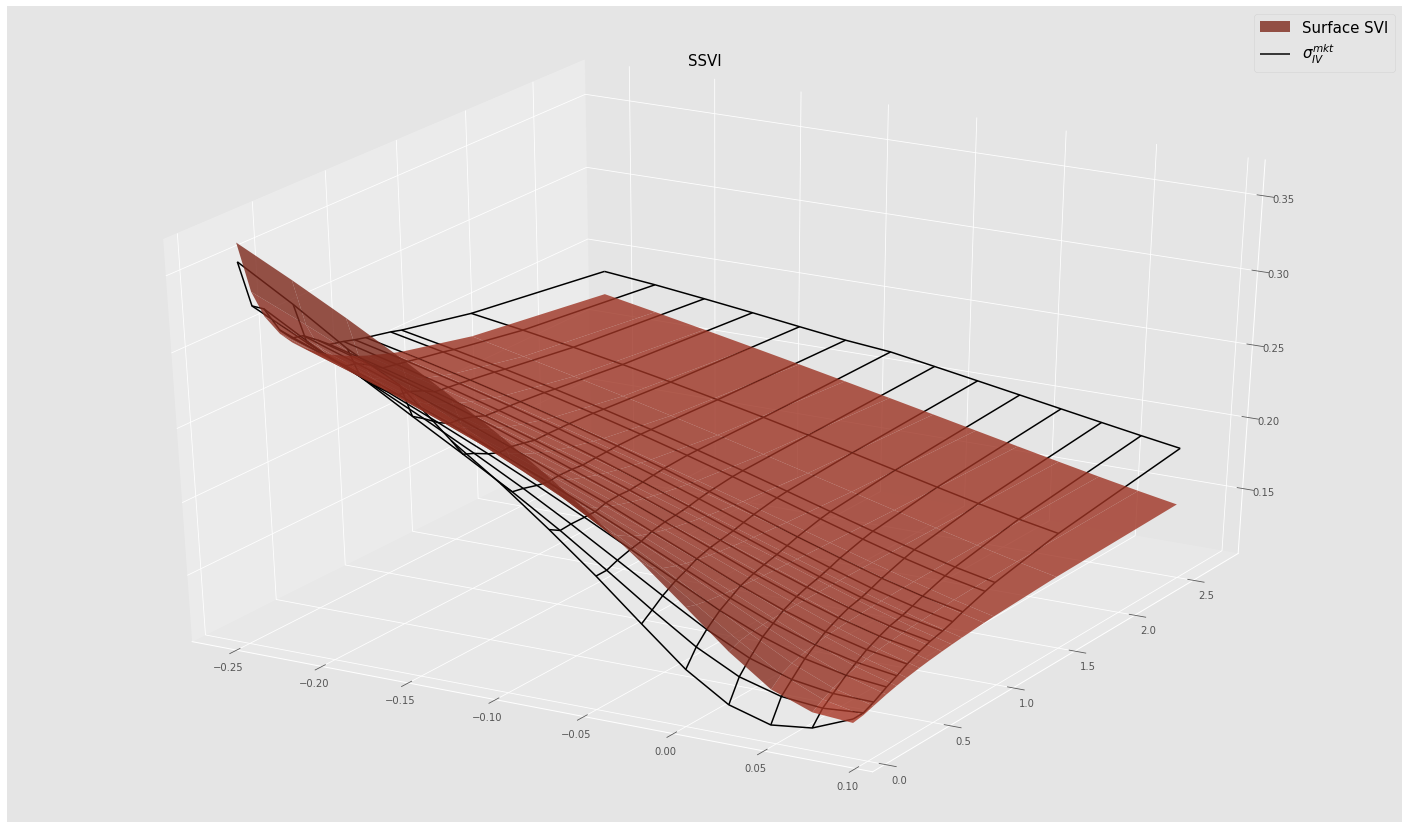

In [388]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(25, 15))
ax = fig.gca(projection='3d')

# Plot a basic wireframe.
#ax.plot_wireframe(xxx, TTT, VSSVI, rstride=10, cstride=10)
c2 = ax.plot_surface(xxx, TTT, VSSVI, rstride=1, cstride=1, linewidth=0,alpha=0.8,\
                     label = 'Surface SVI')
c3 = ax.plot_wireframe(xxx, TTT,Q['Implied Volatility'].values.reshape(15,14)\
                       ,color='black',label = r'$\sigma_{IV}^{mkt}$')
c2._facecolors2d = c2._facecolors3d
c2._edgecolors2d = c2._edgecolors3d
ax.legend(fontsize = 15)
plt.title('SSVI',fontsize = 15)
plt.show()

# Who has the best term structures SV vs Rough Bergomi

In [370]:
def RoughOptimizorATMskew(params,impvol,TTM):
    H,A = params 
    TTM , impvol = args  
    return np.sum((impvol - A * TTM**(H-.5))**2)
bnds = ((1e-3,.499),(-1,-1e-3))
x0 = [0.10,-0.5]
args = L.TTM.unique(),obs
res = minimize(RoughOptimizorATMskew,x0,tol =1e-9,args = args,method = 'SLSQP'\
               ,options = {'disp':True},bounds = bnds)
H_f,A = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005039725928359029
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 7


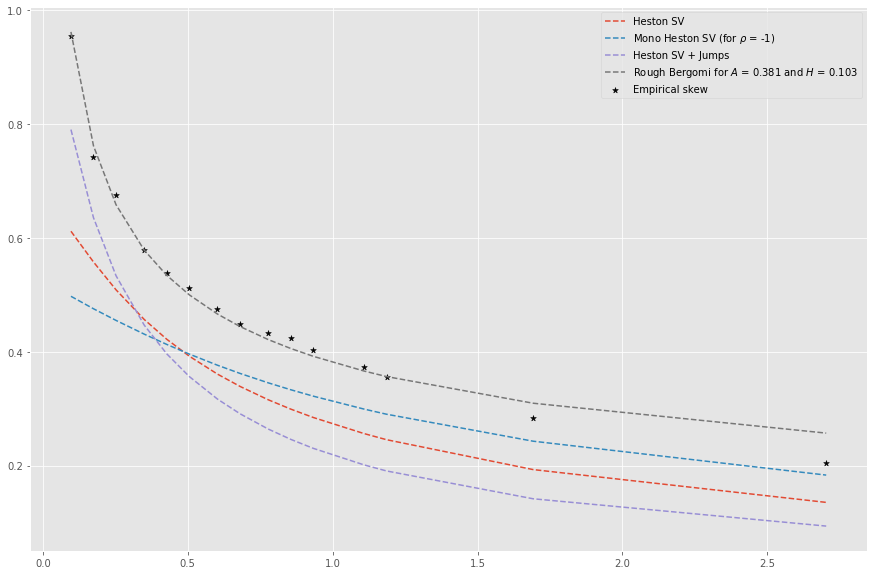

In [371]:
fig = plt.figure(figsize=(15,10))
plt.plot(L.TTM.unique(),-model1,ls = '--',label = r'Heston SV')
plt.plot(L.TTM.unique(),-model2,ls = '--',label = r'Mono Heston SV (for $\rho$ = -1)')
plt.plot(L.TTM.unique(),-model3,ls = '--',label = r'Heston SV + Jumps')
plt.plot(L.TTM.unique(),-A*L.TTM.unique()**(H_f-.5),ls = '--',label = r'Rough Bergomi for $A$ = {} and $H$ = {}'\
        .format(-A.round(3),H_f.round(3)))
plt.scatter(L.TTM.unique(),-obs,color = 'black',marker = '*',label = 'Empirical skew' )
plt.legend()
plt.show()

# Black Sholes Using Characteristic Functions

In [372]:
import numpy as np
from scipy import stats, special, integrate

In [378]:
%%time 

def char_func(x,s,vol,t=1,r=0,L='0'):
    var = vol*vol*t
    if L == '0':
        mean =  (r - 0.5*vol*vol) * t
        w = np.exp(1j*x*mean - x*x*var*0.5)
    else :
        mean =  (r - 0.5*vol*vol) * t
        w = np.exp(mean * (1 + x * 1j) + .5 * var * (1 + x * 1j )**2 )
    return w

def call_value(s,k,vol,t=1,r=0):
    
    def integrand(x,s,k,vol,t=1,r=0,L='1'):
        I = np.exp(-1j*x*np.log(k/s)) * char_func(x,s,vol,t,r,L)/(1j*x)
        return I.real

    def integrand2(x,s,k,vol,t=1,r=0,L='0'):
        I = np.exp(-1j*x*np.log(k/s)) * char_func(x,s,vol,t,r,L)/(1j*x)
        return I.real

    int1 = integrate.quad(integrand,0,50,args=(s,k,vol,t,r))
    int1 = 0.5 + int1[0]/np.pi

    int2 = integrate.quad(integrand2,0,50,args=(s,k,vol,t,r))
    int2 = 0.5 + int2[0]/np.pi
    
    H = int2*np.exp(-0.05*1)/s
            
    return  s*int1 - np.exp(-r*t)*k*int2

call_value(S0,S0,0.2,0.1)

CPU times: user 324 µs, sys: 4 µs, total: 328 µs
Wall time: 333 µs


105.29718605312974